# Dataset Reduction Techniques to Speed Up SVD Analysis

In this _Jupyter Notebook_, we will examine various methods of performing an _SVD_. In particular, we will reduce the size of datasets, represented by simulated _Gaussian Random Fields_, and investigate to what degree the output of the reduced dataset differs from the original. These techniques can be useful when the original dataset is very large and performing analyses is computationally costly. The results from the calculations performed here are reported in an _ISPRS International Journal of Geo-Information_ article [3].

## Initialisation

We start by setting up the necessary tools.

### Imports

The following modules are required in this _Jupyter Notebook_.

In [1]:
import gc
import math
import numpy
import scipy
import scipy.linalg
import sklearn.preprocessing
import matplotlib.pyplot
import pysal

## Functions

The following functions will be used throughout this _Jupyter Notebook_. Some are based on standard matrix algebra [6, 7, 8].

### Helper Functions

The _loop_ function runs the function given as the first argument multiple times, until the uncertainty in the mean of the result of that function is below a certain threshold.

In [2]:
def loop(function, args={}, minIterations=5, maxIterations=100, threshold=0.01):
    results = [function(**args) for i in range(minIterations)]
    while numpy.amax(numpy.std(results, axis=0)) / len(results) > threshold and len(results) < maxIterations:
        results.append(function(**args))
    return numpy.mean(results, axis=0)

The _reduceUSV_ function takes the output of an _SVD_ and removes the smallest _singular values_.

In [3]:
def reduceUSV(U, s, Vt, p):
    U = U[:, :p]
    s = s[:p]
    Vt = Vt[:p]
    return U, s, Vt

The _usvToMatrix_ function takes the output of an _SVD_ and reconstructs the original matrix.

In [4]:
def usvToMatrix(U, s, Vt):
    return U @ numpy.diag(s) @ Vt

The _usvToReducedMatrix_ function combines the previous two functions by reconstructing the original matrix, except for the smallest _singular values_.

In [5]:
def usvToReducedMatrix(U, s, Vt, p):
    U, s, Vt = reduceUSV(U, s, Vt, p)
    return usvToMatrix(U, s, Vt)

The _reduceMatrix_ function performs an _SVD_ on the input matrix, reduces its dimensionality and then reconstructs the matrix.

In [6]:
def reduceMatrix(A, p):
    U, s, Vt = scipy.linalg.svd(A, full_matrices = False)
    return usvToReducedMatrix(U, s, Vt, p)

The _standardiseMatrix_ function centers and standardises the input matrix.

In [7]:
def standardiseMatrix(matrix):
    return (matrix - numpy.mean(matrix)) / numpy.std(matrix)

The _centerAndStandardiseField_ function centers and standardises the input matrix by row.

In [8]:
def centerAndStandardiseField(matrix):
    centeredMatrix = matrix - numpy.mean(matrix, axis=1)[:, None]
    standardDeviation = numpy.std(centeredMatrix, axis=1)[:, None]
    standardDeviation[standardDeviation==0] = 1
    return centeredMatrix / standardDeviation

The _centerAndStandardiseSpatioTemporalField_ function centers and standardises the input matrix by the third axis.

In [9]:
def centerAndStandardiseSpatioTemporalField(matrix):
    centeredMatrix = matrix - numpy.mean(matrix, axis=2)[:, :, None]
    standardDeviation = numpy.std(centeredMatrix, axis=2)[:, :, None]
    standardDeviation[standardDeviation==0] = 1
    return centeredMatrix / standardDeviation

The _normaliseShape_ function crops the array such that an integer number of _nrows_ and _ncols_ fits in its rows and columns.

In [10]:
def normaliseShape(array, nrows, ncols):
    h, w = array.shape
    if h % nrows > 0 or w % ncols > 0:
        array = array[:(h//nrows*nrows), :(w//ncols*ncols)]
    return (h//nrows*nrows), (w//ncols*ncols), array

The _flattenSpatialTemporalFields_ function reshapes two 3D matrices into two 2D matrices.

In [11]:
def flattenSpatialTemporalFields(matrix1, matrix2):
    h, w, d = matrix1.shape
    result1 = matrix1.reshape(h * w, d)
    h, w, d = matrix2.shape
    result2 = matrix2.reshape(h * w, d)
    return result1, result2

The _splitSpatialTemporalField_ function splits a 3D matrix into two 3D matrices by taking alternating slices in the third dimension (i.e. in the time dimension).

In [12]:
def splitSpatialTemporalField(matrixCombined, highCorrelation=True):
    h, w, d = matrixCombined.shape
    if d % 2 > 0:
        print("Error in splitSpatialTemporalField()")
    if highCorrelation:
        d1 = numpy.arange(0, d, 2)
        d2 = numpy.arange(1, d, 2)
    else:
        d1 = numpy.arange(0, d//2)
        d2 = numpy.arange(d//2, d)
    matrix1 = matrixCombined[:, :, d1]
    matrix2 = matrixCombined[:, :, d2]
    return matrix1, matrix2

The _splitAndFlattenSpatialTemporalField_ function combines the previous two functions.

In [13]:
def splitAndFlattenSpatialTemporalField(matrixCombined, highCorrelation=True):
    matrix1, matrix2 = splitSpatialTemporalField(matrixCombined, highCorrelation)
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrix1, matrix2)
    return matrixFlattened1, matrixFlattened2

The _addRectangle_ function adds a rectangle to a plot with some text in the middle.

In [14]:
def addRectangle(axis, left, width, height, text, type=None):
    right = left + width
    patch = matplotlib.patches.Rectangle((left, 1-height), width, height, fill=False, clip_on=False)
    axis.add_patch(patch)
    axis.text(0.5*(left+right), 1-0.5*height, text, horizontalalignment='center', verticalalignment='center', fontsize=14)
    left = right + 0.1
    return axis, left

The _addSymbol_ function adds a symbol, or string of text, to a plot.

In [15]:
def addSymbol(axis, left, symbol, width=0.3, left2=0.1, type=None):
    axis.text(left + left2, 0.85, symbol, horizontalalignment='center', verticalalignment='center', fontsize=14)
    left = left + width
    return axis, left

The _plotMatrixMultiplication_ function takes as input a description of some matrix multiplication and combines the previous two function to make a visualisation of the mathematics.

In [16]:
def plotMatrixMultiplication(matrixDescription=[{}], filePath=None):
    figure, axis = matplotlib.pyplot.subplots()
    matplotlib.pyplot.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)
    matplotlib.pyplot.axis('off')
    figure.set_size_inches(1.5, 1.5)
    left = 0
    for args in matrixDescription:
        if args["type"] is "Matrix":
            axis, left = addRectangle(axis, left, **args)
        elif args["type"] is "Symbol":
            axis, left = addSymbol(axis, left, **args)
    if filePath is not None:
        matplotlib.pyplot.savefig(filePath, bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

The _addBox_ function adds a rectangle with some text to a flow diagram.

In [17]:
def addBox(axis, left=0, bottom=0, text=""):
    patch = matplotlib.patches.Rectangle((left, bottom), 1.84, 0.5, fill=False, clip_on=False)
    axis.add_patch(patch)
    axis.text(left + .92, bottom + .25, text, horizontalalignment='center', verticalalignment='center', fontsize=12)
    return axis

## Introduction

As described in more detail in the accompanying article [3], the method most suitable for size-reduced _SVD_'s depends on the type of dataset. The flow diagram below suggests what technique is likely to be successful. In this _Jupyter Notebook_, we will examine all these techniques by simulating _Gaussian Random Fields_.

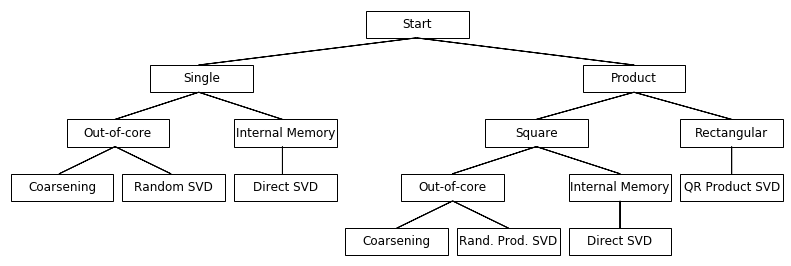

In [18]:
figure, axis = matplotlib.pyplot.subplots()
matplotlib.pyplot.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)
matplotlib.pyplot.axis('off')
figure.set_size_inches(13.8, 4.5)
matplotlib.pyplot.xlim([0,13.8])
matplotlib.pyplot.ylim([0,4.5])
axis = addBox(axis, left=6.37, bottom=4, text="Start")
axis = addBox(axis, left=2.5, bottom=3, text="Single")
axis = addBox(axis, left=1, bottom=2, text="Out-of-core")
axis = addBox(axis, left=0, bottom=1, text="Coarsening")
axis = addBox(axis, left=2, bottom=1, text="Random SVD")
axis = addBox(axis, left=4, bottom=2, text="Internal Memory")
axis = addBox(axis, left=4, bottom=1, text="Direct SVD")
axis = addBox(axis, left=10.25, bottom=3, text="Product")
axis = addBox(axis, left=8.5, bottom=2, text="Square")
axis = addBox(axis, left=7, bottom=1, text="Out-of-core")
axis = addBox(axis, left=6, bottom=0, text="Coarsening")
axis = addBox(axis, left=8, bottom=0, text="Rand. Prod. SVD")
axis = addBox(axis, left=10, bottom=1, text="Internal Memory")
axis = addBox(axis, left=10, bottom=0, text="Direct SVD")
axis = addBox(axis, left=12, bottom=2, text="Rectangular")
axis = addBox(axis, left=12, bottom=1, text="QR Product SVD")
matplotlib.pyplot.arrow(7.27, 4, -3.9, -0.5)
matplotlib.pyplot.arrow(3.37, 3, -1.5, -0.5)
matplotlib.pyplot.arrow(1.87, 2, -1, -0.5)
matplotlib.pyplot.arrow(1.87, 2, 1, -0.5)
matplotlib.pyplot.arrow(3.37, 3, 1.5, -0.5)
matplotlib.pyplot.arrow(4.87, 2, 0, -0.5)
matplotlib.pyplot.arrow(7.27, 4, 3.9, -0.5)
matplotlib.pyplot.arrow(11.17, 3, -1.75, -0.5)
matplotlib.pyplot.arrow(9.42, 2, -1.5, -0.5)
matplotlib.pyplot.arrow(7.92, 1, -1, -0.5)
matplotlib.pyplot.arrow(7.92, 1, 1, -0.5)
matplotlib.pyplot.arrow(9.42, 2, 1.5, -0.5)
matplotlib.pyplot.arrow(10.92, 1, 0, -0.5)
matplotlib.pyplot.arrow(11.17, 3, 1.75, -0.5)
matplotlib.pyplot.arrow(12.92, 2, 0, -0.5)
matplotlib.pyplot.savefig("Results/FlowDiagram.pdf", bbox_inches="tight", pad_inches=0)
matplotlib.pyplot.show()

### Gaussian Random Spatial Field

The _gaussianRandomSpatialField_ function generates a 2D matrix representing a _Gaussian Random Field_ where the power spectrum follows a power law with exponent -$\alpha$. The resulting matrix is scaled such that it has zero mean and unit standard deviation.

In [19]:
def gaussianRandomSpatialField(alpha=2.0, size=100):
    # Based on: http://andrewwalker.github.io/statefultransitions/post/gaussian-fields/
    noise = numpy.fft.fft2(numpy.random.normal(size=(size, size)))
    mesh = numpy.meshgrid(range(-size//2, size//2), range(-size//2, size//2))
    distance = numpy.power(mesh[0], 2, dtype=numpy.float32) + numpy.power(mesh[1], 2, dtype=numpy.float32)
    distance[size//2, size//2] = numpy.inf
    amplitude = numpy.power(distance, -alpha/4.0)
    amplitude = numpy.fft.ifftshift(amplitude)
    result = numpy.fft.ifft2(noise * amplitude).real
    result = standardiseMatrix(result)
    return result

The _getGaussianPowerSpectrum_ function takes a 2D matrix, assumes it represents a rotationally invariant _Gaussian Random Field_ and return the power spectrum of the field.

In [20]:
def getGaussianPowerSpectrum(dataArray):
    if len(dataArray.shape) == 3:
        h, w, d = dataArray.shape
        mesh = numpy.meshgrid(range(-h//2, h//2), range(-w//2, w//2), range(-d//2, d//2))
        wavesFlattened = numpy.power(numpy.power(mesh[0], 2) + numpy.power(mesh[1], 2) + numpy.power(mesh[2], 2), 1/4).flatten()
    else:
        h, w = dataArray.shape
        mesh = numpy.meshgrid(range(-h//2, h//2), range(-w//2, w//2))
        wavesFlattened = numpy.power(numpy.power(mesh[0], 2) + numpy.power(mesh[1], 2), 1/4).flatten()
    fft = numpy.fft.fftn(dataArray)
    fftShifted = numpy.fft.fftshift(fft)
    fftAbs = numpy.abs(fftShifted)
    fftFlattened = fftAbs.flatten()
    mask = wavesFlattened == 0
    wavesMasked = wavesFlattened[~mask]
    fftMasked = fftFlattened[~mask]
    mask2 = numpy.log(fftMasked) < -20
    wavesMasked2 = wavesMasked[~mask2]
    fftMasked2 = fftMasked[~mask2]
    return wavesMasked2, fftMasked2

The _estimateGaussianPowerLaw_ function takes a 2D matrix, assumes it represents a rotationally invariant _Gaussian Random Field_ and estimates the exponent of the power law which fits the power spectrum of the field.

In [21]:
def estimateGaussianPowerLaw(dataArray, waves=None, fft=None):
    if waves is None or fft is None:
        waves, fft = getGaussianPowerSpectrum(dataArray)
    wavesLog = numpy.log(waves)
    fftLog = numpy.log(fft)
    estimatedAlpha, estimatedIntercept, r_value, p_value, std_err = scipy.stats.linregress(wavesLog, fftLog)
    estimatedRSquared = r_value**2
    return -estimatedAlpha, estimatedIntercept, estimatedRSquared

The _explainedVariance_ function takes the list of singular values of a matrix and determines the amount of variance in the dataset explained by each singular mode.

In [22]:
def explainedVariance(s):
    x = numpy.arange(1, len(s) + 1)
    total = s.T @ s
    cumulativeValue = 0
    valueList = numpy.square(s) / total
    cumulativeList = numpy.cumsum(valueList)
    mask = valueList > 10**-3
    x = x[mask]
    valueList = valueList[mask]
    cumulativeList = cumulativeList[mask]
    return x, valueList, cumulativeList

The _estimateSingularValuesPowerLaw_ function takes a 2D matrix, assumes its singular values fit a power law and estimates the exponent of the power law. We call the exponent $\beta$.

In [23]:
def estimateSingularValuesPowerLaw(singularValues):
    x = numpy.log(list(range(1, len(singularValues) + 1)))
    y = numpy.log(singularValues)
    mask = y < -20
    x = x[~mask]
    y = y[~mask]
    estimatedBeta, estimatedIntercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    estimatedBetaRSquared = r_value**2
    return -estimatedBeta, estimatedIntercept, estimatedBetaRSquared

Let's plot some _Gaussian Random Fields_ of various sizes and various $\alpha$'s. Let's also test the _estimateGaussianPowerLaw_ function by applying it to the generated datasets and comparing the result with the true $\alpha$. As can be seen, the $\alpha$ is a measure of the spatial autocorrelation of the field. In particular, fields with large scale structure have a larger $\alpha$. Additionally, the size of the _singular values_ can be plotted. This is related to the power spectrum and will also provide information about the scale of the structure in the field.

Size: 100 | Alpha: 1.000
Estimated Alpha: 1.011 | r^2: 0.131
Estimated Beta: 1.009 | r^2: 0.795


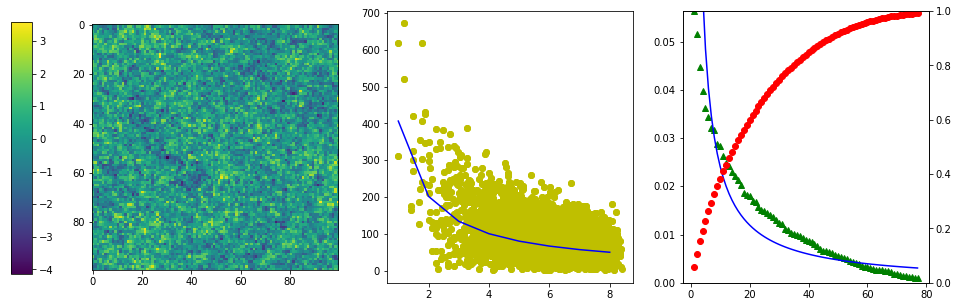

Size: 100 | Alpha: 3.000
Estimated Alpha: 3.018 | r^2: 0.603
Estimated Beta: 2.024 | r^2: 0.992


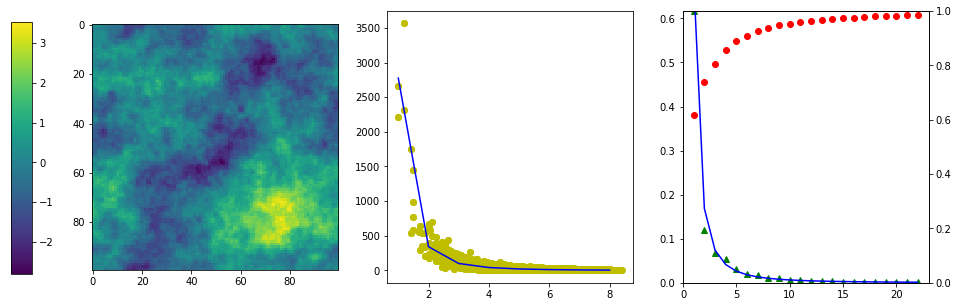

Size: 100 | Alpha: 5.000
Estimated Alpha: 5.012 | r^2: 0.796
Estimated Beta: 3.225 | r^2: 0.894


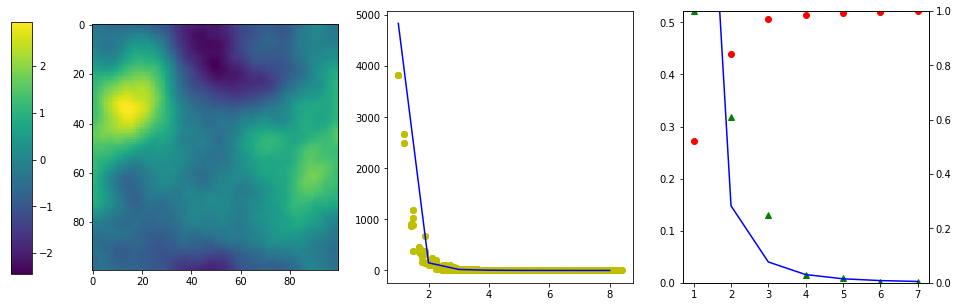

Size: 200 | Alpha: 1.000
Estimated Alpha: 1.001 | r^2: 0.136
Estimated Beta: 0.834 | r^2: 0.829


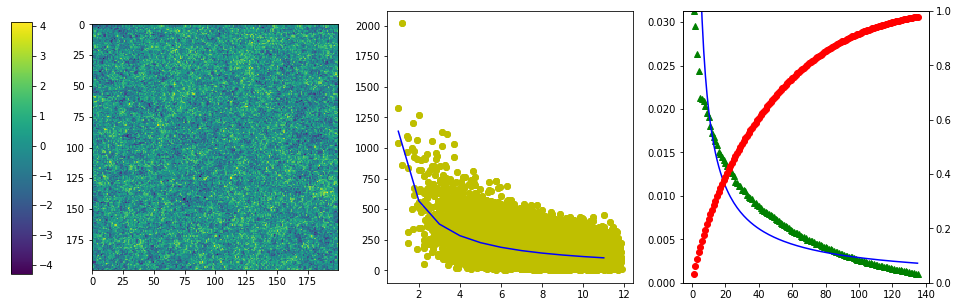

Size: 200 | Alpha: 3.000
Estimated Alpha: 2.946 | r^2: 0.576
Estimated Beta: 1.920 | r^2: 0.990


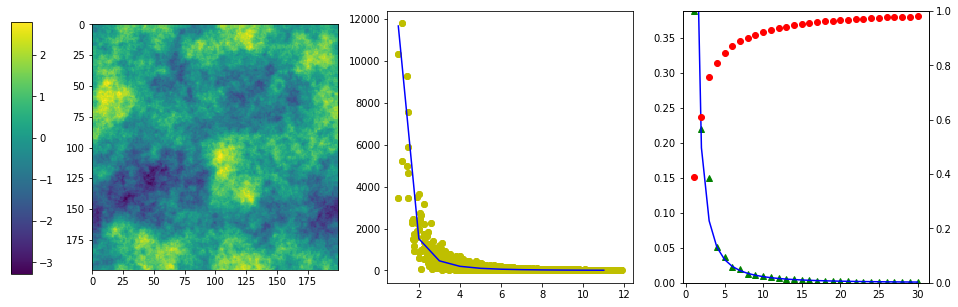

Size: 200 | Alpha: 5.000
Estimated Alpha: 4.995 | r^2: 0.800
Estimated Beta: 3.105 | r^2: 0.848


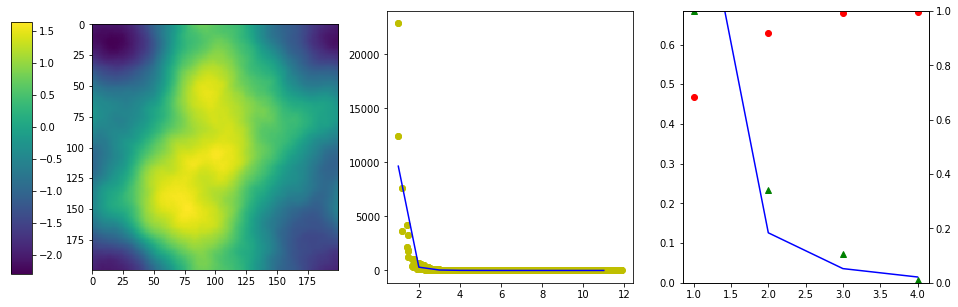

Size: 400 | Alpha: 1.000
Estimated Alpha: 1.004 | r^2: 0.139
Estimated Beta: 0.687 | r^2: 0.867


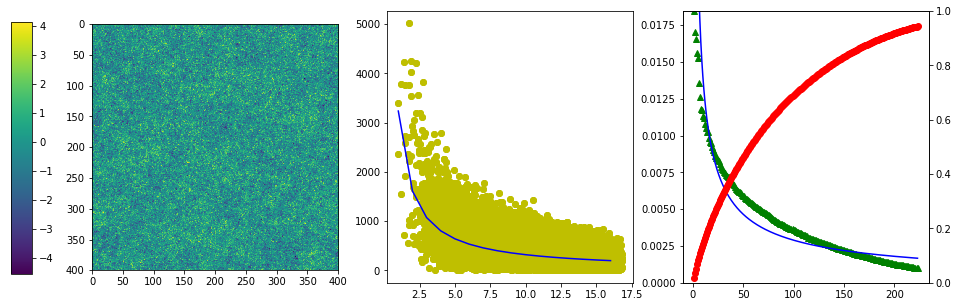

Size: 400 | Alpha: 3.000
Estimated Alpha: 2.996 | r^2: 0.588
Estimated Beta: 2.188 | r^2: 0.988


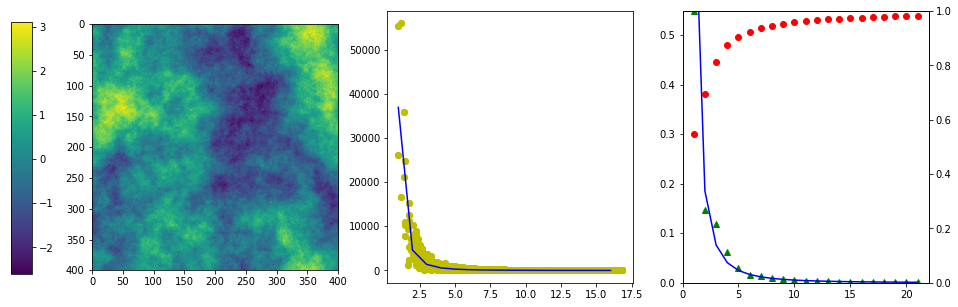

Size: 400 | Alpha: 5.000
Estimated Alpha: 5.004 | r^2: 0.800
Estimated Beta: 3.831 | r^2: 0.890


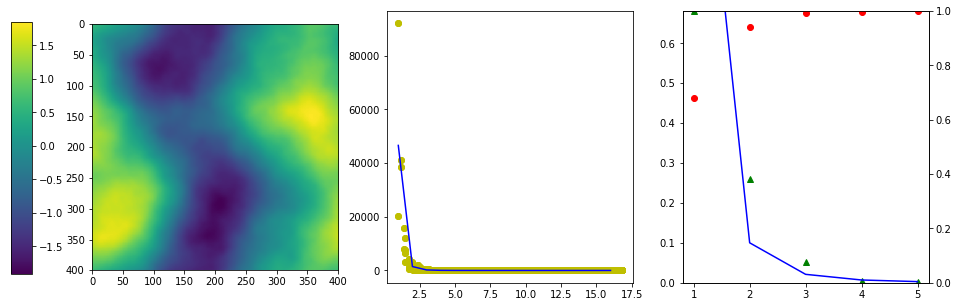

In [24]:
for size in [100, 200, 400]:
    for alpha in [1, 3, 5]:
        data = gaussianRandomSpatialField(alpha, size)
        wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
        estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
        U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
        x, valueList, cumulativeList = explainedVariance(s)
        estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
        print("Size: {:d} | Alpha: {:0.3f}".format(size, alpha))
        print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
        print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
        fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
        im = ax1.imshow(data)
        extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        ax1.axis('off')
        fig.savefig("Results/GaussianRandomFieldSize{:d}Alpha{:d}.pdf".format(size, alpha), bbox_inches=extent, pad_inches=0)
        ax1.axis('on')
        cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax = cbaxes)
        ax2.plot(wavesMasked, fftMasked, "yo")
        ax2.plot(range(1, 1 + int(max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, 1 + int(max(wavesMasked))), -estimatedAlpha), "b-")
        ax3.plot(x, valueList, "g^")
        ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
        ax3b = ax3.twinx()
        ax3.set_ylim(0, valueList[0])
        ax3b.set_ylim(0, 1)
        ax3b.plot(x, cumulativeList, "ro")
        matplotlib.pyplot.show()

### Gaussian Random Spatio-Temporal Field

In many real-world applications, the analysis of a field does not only involve a single _time period_. In fact, it often includes data over multiple weeks, months or years, where the field over the entire time period does not change drastically. Just as there is spatial autocorrelation, there is temporal autocorrelation. The _gaussianRandomSpatialTemporalField_ function generates a 3D matrix where the third dimension represent _time_. In principle, there can be a different level of correlation over time than over space. However, for simplicity, we are using the same $\alpha$ determine the level of autocorrelation in all dimensions.

In [25]:
def gaussianRandomSpatialTemporalField(alpha=2.0, spatialSize=100, temporalSize=60):
    noise = numpy.fft.fftn(numpy.random.normal(size=(spatialSize, spatialSize, temporalSize)))
    mesh = numpy.meshgrid(range(-spatialSize//2, spatialSize//2), range(-spatialSize//2, spatialSize//2), range(-temporalSize//2, temporalSize//2))
    distance = numpy.power(mesh[0], 2, dtype=numpy.float64) + numpy.power(mesh[1], 2, dtype=numpy.float64) + numpy.power(mesh[2], 2, dtype=numpy.float64)
    distance[spatialSize//2, spatialSize//2, temporalSize//2] = numpy.inf
    amplitude = numpy.power(distance, -alpha/4.0)
    amplitude = numpy.fft.ifftshift(amplitude)
    result = numpy.fft.ifftn(noise * amplitude).real
    result = (result - numpy.mean(result)) / numpy.std(result)
    return result

We can plot various _time periods_ of a spatial field next to each other, which will show how the field evolves in time. These changes will occur rapidly for smaller $\alpha$ and more slowly for larger $\alpha$. The _estimateGaussianPowerLaw_ function can, again, be used to estimate $\alpha$ based on the data.

Spatial Size: 100 | Alpha: 1.000
Estimated Alpha: 1.028 | r^2: 0.143


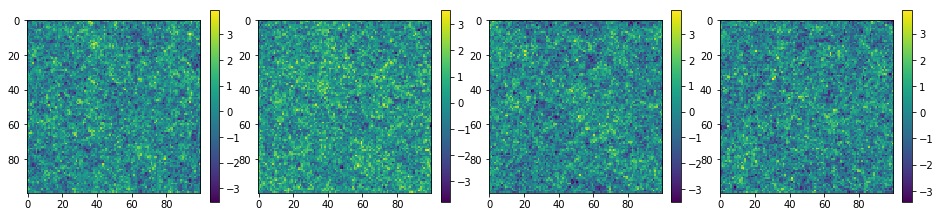

Spatial Size: 100 | Alpha: 3.000
Estimated Alpha: 2.995 | r^2: 0.576


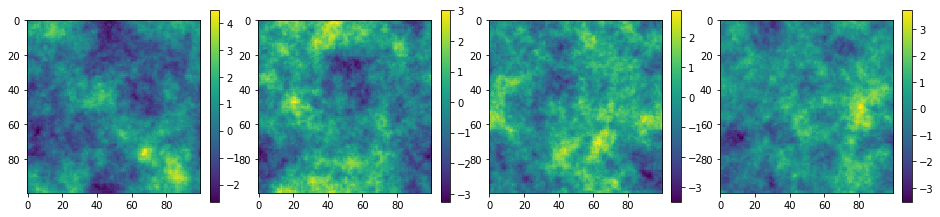

Spatial Size: 100 | Alpha: 5.000
Estimated Alpha: 4.978 | r^2: 0.789


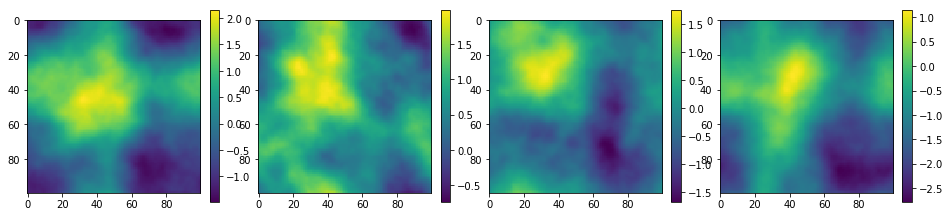

Spatial Size: 200 | Alpha: 1.000
Estimated Alpha: 0.990 | r^2: 0.134


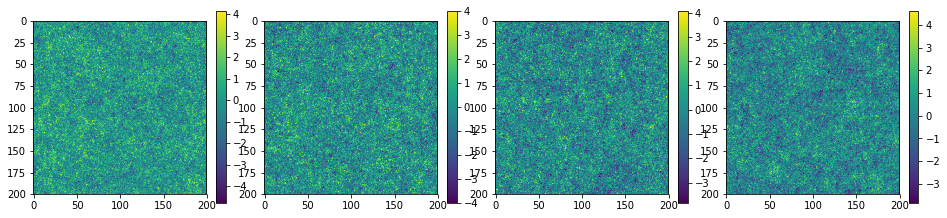

Spatial Size: 200 | Alpha: 3.000
Estimated Alpha: 3.004 | r^2: 0.585


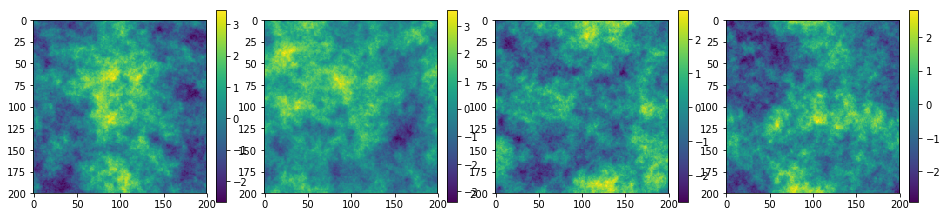

Spatial Size: 200 | Alpha: 5.000
Estimated Alpha: 5.018 | r^2: 0.800


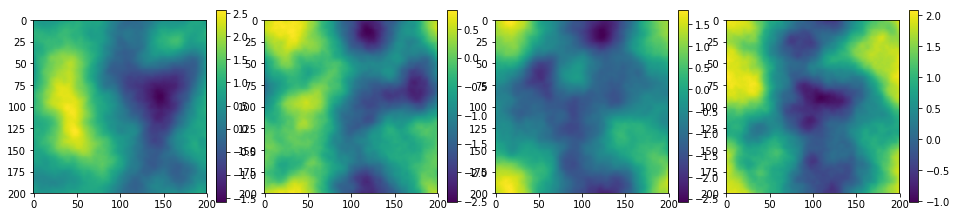

Spatial Size: 400 | Alpha: 1.000
Estimated Alpha: 0.999 | r^2: 0.138


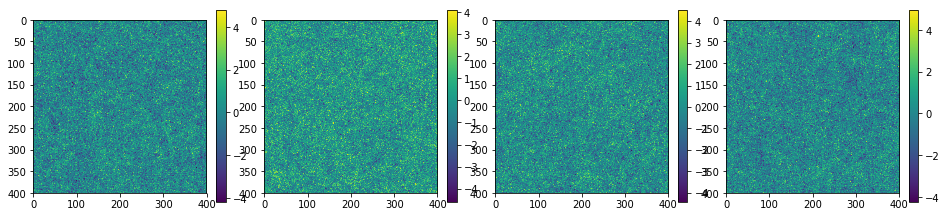

Spatial Size: 400 | Alpha: 3.000
Estimated Alpha: 2.998 | r^2: 0.587


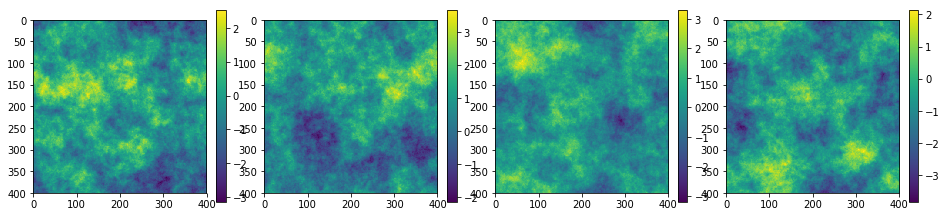

Spatial Size: 400 | Alpha: 5.000
Estimated Alpha: 5.001 | r^2: 0.799


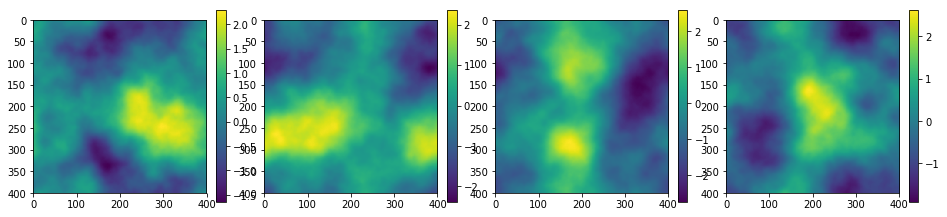

In [26]:
temporalSize=4
for spatialSize in [100, 200, 400]:
    for alpha in [1, 3, 5]:
        data = gaussianRandomSpatialTemporalField(alpha, spatialSize, temporalSize)
        estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data)
        print("Spatial Size: {:d} | Alpha: {:0.3f}".format(spatialSize, alpha))
        print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
        matplotlib.pyplot.figure(figsize=(20, 20))
        for i in range(temporalSize):
            matplotlib.pyplot.subplot(1, temporalSize + 1, i + 1)
            matplotlib.pyplot.imshow(data[:, :, i])
            matplotlib.pyplot.colorbar(fraction=0.05)
        matplotlib.pyplot.show()

In order to keep our _Jupyter Notebook_ running efficiently, it is important to actively _collect garbage_.

In [27]:
_ = gc.collect()

### Moran's I

There are multiple measures of spatial autocorrelation. One which is frequently used in the _geosciences_ is Moran's $I$ [7, 10, 13, 14, 16]. Altough, the Python module _pysal_ has a function to determine Moran's $I$, it is very slow, especially for kernels with a large bandwidth.

Therefore, let's define a function which approximates Moran's $I$, for 2D spatial fields such as ours and for a uniform kernel. As Moran's $I$ examines the similarity between neighbouring cells, this function cuts a spatial field into multiple small squares of neighbouring cells.

The _sumOfCovariance_ function simply sums the covariance matrix of a vector over the upper triangle.

In [28]:
def sumOfCovariance(data):
    return (numpy.sum(numpy.outer(data, data)) - numpy.dot(data, data)) / data.shape[0] / (data.shape[0] - 1)

The _approximateMoransI_ functions cuts a 2D spatial dataset into multiple squares of size equal to the _bandwidth + 1_. Then, the covariances of all of these squares is summed.

In [29]:
def approximateMoransI(data, bandwidth=4):
    bandwidth += 1
    h, _, data = normaliseShape(data, bandwidth, bandwidth)
    data = standardiseMatrix(data)
    matrixToVector = data.reshape(h//bandwidth, bandwidth, -1, bandwidth).swapaxes(1, 2).reshape(-1, bandwidth**2)
    return numpy.mean(numpy.apply_along_axis(sumOfCovariance, 1, matrixToVector))

Let's test and compare Moran's $I$ and our approximation function. The function for Moran's $I$ in the _pysal_ module requires a weight matrix. To create this matrix using a uniform kernel with some bandwidth, the indices of the spatial points are used. Obviously, we need to use a similar bandwidth in our approximation. Finally, the _testApproximateMoransI_ function generates a 2D spatial field and determines Moran's $I$ and the approximation.

In [30]:
def testApproximateMoransI(size=60, alpha=2, bandwidth=4):
    data = gaussianRandomSpatialField(alpha, size)
    y = data.flatten()
    meshX, meshY = numpy.meshgrid(numpy.arange(size), numpy.arange(size))
    latticeCoordinates = numpy.column_stack((meshY.ravel(), meshX.ravel()))
    w = pysal.Kernel(latticeCoordinates, bandwidth=bandwidth, function='uniform')
    mi = pysal.Moran(y, w, permutations=0)
    return mi.I, approximateMoransI(data, bandwidth=bandwidth)

The following two numbers are Moran's $I$ and its approximation. By varying the size, the $\alpha$ and the bandwidth we can find their dependency on these parameters. It seems our approximation gives a good representation of Moran's $I$. Initially, it overestimated the measure slightly, but incrementing the bandwidth has improved this.

In [31]:
loop(testApproximateMoransI)

array([0.47207864, 0.47647862])

Moran's $I$ shows substantial dependency on size. We will not explore this further here, but it would be interesting to investigate this effect in the future. Our approximation shows the same effect.

In [32]:
loop(testApproximateMoransI, {"size": 40})

array([0.48812362, 0.48213182])

In [33]:
loop(testApproximateMoransI, {"size": 100})

array([0.52055147, 0.52227168])

When $\alpha$ is smaller, the _Gaussian Random Field_ has smaller scale structure. It is closer to randomness and has less autocorrelation. As expected, the effect can be seen in the two measures of autocorrelation.

In [34]:
loop(testApproximateMoransI, {"alpha": 0.5})

array([0.06005857, 0.0473901 ])

In [35]:
loop(testApproximateMoransI, {"alpha": 1})

array([0.13824574, 0.12877939])

In [36]:
loop(testApproximateMoransI, {"alpha": 2})

array([0.47245612, 0.46599284])

In [37]:
loop(testApproximateMoransI, {"alpha": 3})

array([0.82893077, 0.82646689])

In [38]:
loop(testApproximateMoransI, {"alpha": 4})

array([0.92945719, 0.92756182])

Larger bandwidths capture more variation, leading to smaller values of Moran's $I$. This can also be seen in our simulations. The appropriate bandwidth to use depends on the level of autocorrelation in the dataset. Only comparisons of Moran's $I$ using the same bandwidth make sense.

In [39]:
loop(testApproximateMoransI, {"bandwidth": 2})

array([0.65476748, 0.60095726])

In [40]:
loop(testApproximateMoransI, {"bandwidth": 6})

array([0.37949266, 0.40419948])

To find a more precise relation between the $\alpha$ of a _Gaussian Random Fields_ and the other measures of spatial autocorrelation, let's generate various fields for different sizes and different $\alpha$'s. We can then calculate $\beta$ and Moran's $I$ as a function of $\alpha$.

In [41]:
def testMoransIAndBeta(size=200, alpha=2, bandwidth=10):
    data = gaussianRandomSpatialField(alpha, size)
    U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
    estimatedBeta, _, _ = estimateSingularValuesPowerLaw(s)
    mi = approximateMoransI(data, bandwidth=bandwidth)
    return mi, estimatedBeta

In [42]:
def plotMoransIAndBeta(size=200):
    alphas = numpy.arange(0.25, 4.1, 0.25)
    line1 = []
    line2 = []
    for alpha in alphas:
        value = loop(testMoransIAndBeta, {"size": size, "alpha": alpha})
        line1.append(value[0])
        line2.append(value[1])
    matplotlib.pyplot.plot(alphas, line1)
    matplotlib.pyplot.plot(alphas, line2)
    matplotlib.pyplot.legend([r"Moran's $I$", r"$\beta$"])
    matplotlib.pyplot.xlabel(r"$\alpha$")
    matplotlib.pyplot.ylabel("autocorrelation")
    matplotlib.pyplot.savefig("Results/plotMoransIAndBeta.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

The plot below indeed shows the positive correlation of $\alpha$, Moran's $I$ and $\beta$. Note that we used a bandwidth equal to $10$ gridpoints for the kernel in Moran's $I$. Subsequent analyses will define the scale of the field's structure in terms of $\alpha$. This plot can help _translate_ this measure to the other measures of autocorrelation.

In real world applications, datasets are not _Gaussian Random Fields_ and the relation between $\alpha$, Moran's $I$ and $\beta$ will not be so precise. Furthermore. due to the size dependency of Moran's $I$, this plot does not describe the entire picture even for the _Gaussian Random Fields_ case. Nonetheless, it does provide an idea of the relations between the three measures.

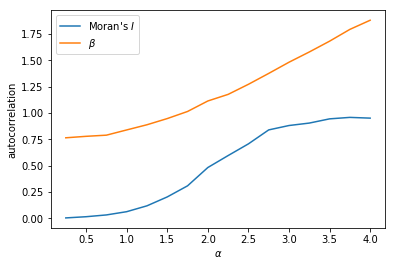

In [43]:
plotMoransIAndBeta()

In [44]:
_ = gc.collect()

## Efficient SVD Techniques

This section will discuss four techniques to analyse large datasets efficiently using _SVD_, by exploiting rank deficiency and autocorrelation. We will generate various _Gaussian Random Fields_, apply our techniques and compare the reults.

One method to capture the similarity between two field is to determine the norm of the difference between these two datasets. The $L2$ norm, also known as the _Frobenius norm_, simply captures the total variance in the dataset. By dividing the variance in the difference of two datasets with the variance of the original dataset, a simple measure of their (dis)similarity is established. Note that two _Gaussian Random Fields_, on average, will have a dissimilarity of 1.41 (i.e. $\sqrt2$) as they are independently drawn and orthogonal to each other.

Another measure which could have been used, is the _Pearson correlation_ between the two datasets. Two identical fields have a correlation equal to $1$ and two independently drawn _Gaussian Random Fields_ have a correlation of $0$. We leave this measure for further research.

In this work, the term _efficiency_ is related to the concept of rank deficiency. A calculation is called _efficient_ if it never requires the construction of a rank deficient (i.e. an unnecessarily large) intermediate matrix.

### Efficient Exact Norm Difference via SVD

In real-world application, one often wants to find the norm of the difference between two fields. This can be done by subtracting one matrix from the other and calculating the norm. However, for large matrices, a more efficient method is available when a rank decomposition, such as the _SVD_, is already known. The _normDifferenceFromUSVs_ function can take such input _SVDs_ and determine the norm of their difference in an efficient manner, provided the number of singular values is small. The result is mathematically identical to the full calculation, which means that any error will be of the order of machine-precision.

In [45]:
def normDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2):
    if U1.shape != U2.shape or s1.shape != s2.shape or Vt1.shape != Vt2.shape:
        print("Error in normDifferenceFromUSVs: shapes do not match.")
        return 0
    AA = s1 @ s1
    BB = s2 @ s2
    AB = s1 @ numpy.multiply(U1.T @ U2, Vt1 @ Vt2.T) @ s2
    return math.sqrt(AA + BB - 2 * AB)

If one is interested in the percentage difference of the second matrix compared with the first, the _percentageNormDifferenceFromUSVs_ function will use the output of the previous function and compare this to the norm of the first matrix, which is simply the sum of its singular values squared.

In [46]:
def percentageNormDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2):
    return normDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2) / math.sqrt(s1 @ s1)

The image below depicts the calculations performed in the functions above. It shows that for rank deficient datasets, i.e. ones with small numbers of singular modes, the calculation never requires the construction of an inefficiently large intermediate matrix.

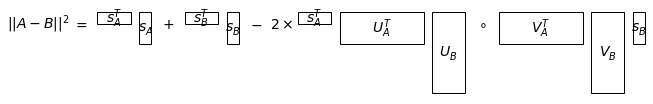

In [47]:
matrixDescription = [
    {"type":"Symbol", "symbol":r"$||A-B||^{2}$", "width":0.5},
    {"type":"Symbol", "symbol":r"$=$"},
    {"type":"Matrix", "width":0.4, "height":0.15, "text":r"$s_{A}^{T}$"},
    {"type":"Matrix", "width":0.15, "height":0.4, "text":r"$s_{A}^{}$"},
    {"type":"Symbol", "symbol":"+"},
    {"type":"Matrix", "width":0.4, "height":0.15, "text":r"$s_{B}^{T}$"},
    {"type":"Matrix", "width":0.15, "height":0.4, "text":r"$s_{B}^{}}$"},
    {"type":"Symbol", "symbol":r"$-$"},
    {"type":"Symbol", "symbol":r"$2 \times$", "width":0.3},
    {"type":"Matrix", "width":0.4, "height":0.15, "text":r"$s_{A}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.4, "text":r"$U_{A}^{T}$"},
    {"type":"Matrix", "width":0.4, "height":1, "text":r"$U_{B}^{}$"},
    {"type":"Symbol", "symbol":r"$\circ$"},
    {"type":"Matrix", "width":1, "height":0.4, "text":r"$V_{A}^{T}$"},
    {"type":"Matrix", "width":0.4, "height":1, "text":r"$V_{B}^{}$"},
    {"type":"Matrix", "width":0.15, "height":0.4, "text":r"$s_{B}^{}$"}
]
plotMatrixMultiplication(matrixDescription, "Results/normDifferenceFromUSVs.pdf")

To verify experimentally that the _normDifferenceFromUSVs_ function indeed produces an output identical to the full norm difference, let's generate a _Gaussian Random Field_ and run both types of calculation.

In [48]:
def testNormDifferenceFromUSVs(size=200, alpha=2):
    matrix1 = gaussianRandomSpatialField(alpha, size)
    matrix2 = gaussianRandomSpatialField(alpha, size)
    matrixDifference = matrix1 - matrix2
    normDifference = scipy.linalg.norm(matrixDifference)
    U1, s1, Vt1 = scipy.linalg.svd(matrix1, full_matrices = False)
    U2, s2, Vt2 = scipy.linalg.svd(matrix2, full_matrices = False)
    normDifference2 = normDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2)
    return numpy.isclose(normDifference, normDifference2)

As expected, the results are identical up to machine-precision.

In [49]:
testNormDifferenceFromUSVs()

True

In [50]:
_ = gc.collect()

### Efficient Exact SVD via QR Decomposition

In real-world applications, it may be interesting to find the relation between two fields. This can be done by performing an _SVD_ on the cross-correlation matrix of these two fields. Typically, the two input datasets have the various spatial gridpoint as rows and the sample of recorded values over time as columns. Multiplying two fields by row gives the cross-correlation matrix.

However, for highly rectangular matrices, when there are many spatial gridpoint but few temporal samples, the resulting cross-correlation matrix is rank deficient and inefficiently large. The _qrProductSVD_ function can take such input data and perform an _SVD_ in an efficient manner [2, 5, 15]. The result is mathematically identical to the full _SVD_, which means that the difference will be at machine-precision.

In [51]:
def qrProductSVD(A, B):
    # Based on a suggestion from Mark Tygert during personal communication [15]
    QA, RA = scipy.linalg.qr(A, mode = "economic")
    QB, RB = scipy.linalg.qr(B, mode = "economic")
    C = RA @ RB.T
    UC, s, VCt = scipy.linalg.svd(C, full_matrices = False)
    U = QA @ UC
    Vt = VCt @ QB.T
    return U, s, Vt

The following figure shows the steps in this calculation. Note that the rank decomposition leads to the same SVD output without ever creating the rank deficient cross-correlation matrix.

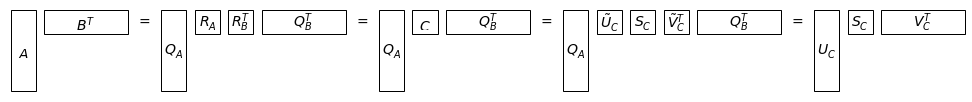

In [52]:
matrixDescription = [
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$B_{}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$Q_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$R_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$R_{B}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$Q_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$Q_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$C_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$Q_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$Q_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{U}_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{V}_{C}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$Q_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$U_{C}^{}}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$V_{C}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/qrProductSVD.pdf")

To verify experimentally that the _qrProductSVD_ function indeed produces an output identical to the full _SVD_, let's generate a _Gaussian Random Spatio-Temporal Field_ and run both types of _SVD_.

In [53]:
def testQRProductSVD(spatialSize=60, temporalSize=40, alpha=2):
    matrixBoth = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrix1 = matrixBoth[:, :, :temporalSize]
    matrix2 = matrixBoth[:, :, temporalSize:]
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrix1, matrix2)
    productMatrix = matrixFlattened1 @ matrixFlattened2.T
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    reconstructedMatrix = usvToMatrix(U, s, Vt)
    return numpy.allclose(productMatrix, reconstructedMatrix)

As expected, the results are identical up to machine-precision.

In [54]:
testQRProductSVD()

True

In [55]:
_ = gc.collect()

### Efficient Approximate SVD via Spatial Coarsening

Although the _qrProductSVD_ function works well for two rectangular matrices, sometimes the input data is large and square. Other methods can be used which provide an approximate answer. Given a desired level of accuracy, reducing the datasets before performing the _SVD_ may significantly speed up the analysis.

#### Single Spatial Field via Spatial Coarsening

When a field has large scale structure, the values of neighbouring cells do not change drastically. This is what autocorrelation means. As such, perhaps neighbouring cells can be averaged together to produce a smaller dataset which still faithfully describes the original field. The _coarsenMatrix_ function first cuts the input matrix into smaller sections and then averages each section, reducing the spatial size. It then knits the sections back together, resulting in a matrix which is $level^{2}$ times smaller.

In [56]:
def coarsenMatrix(array, level):
    h, w, array = normaliseShape(array, level, level)
    arrayReshaped = array.reshape((h // level, level, w // level, level))
    return numpy.nanmean(arrayReshaped, axis=(1,3))

The _uncoarsenMatrix_ function does the reverse of the previous function. It enlarges each cells, resulting in a matrix which is $level^{2}$ times bigger.

In [57]:
def uncoarsenMatrix(matrix, level):
    return numpy.repeat(numpy.repeat(matrix, level, axis=0), level, axis=1)

To see the effect of spatial coarsening, let's generate a _Gaussian Random Field_ and plot it together with a coarsened version. To be able to compare the two matrices, they need to be of the same size. Therefore, we also uncoarsen the coarsened matrix. The difference with the original field is shown in a plot. The norm of the difference between the uncoarsened matrix and the original shows the amount of information lost in the coarsening process.

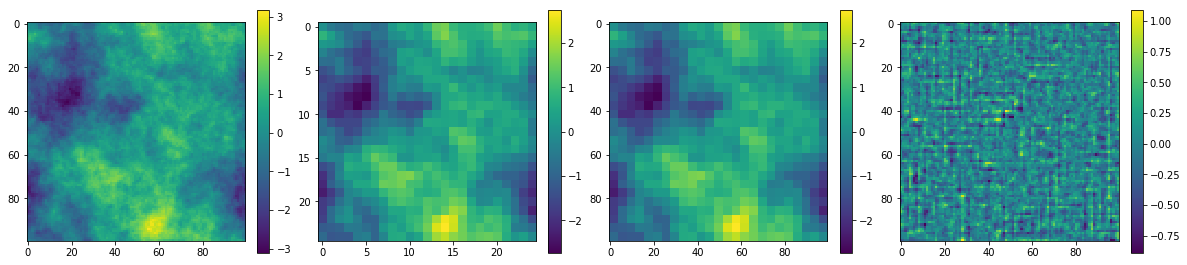

Norm original matrix: 100.0
Norm coarsened matrix: 24.270419091822426
Norm uncoarsened matrix: 97.0816763672897
Norm of their difference: 23.982245802193376
Percentage difference: 0.23982245802193375


In [58]:
matrix = gaussianRandomSpatialField(alpha=3, size=100)
coarsenedMatrix = coarsenMatrix(matrix, 4)
uncoarsenedMatrix = uncoarsenMatrix(coarsenedMatrix, 4)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(coarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(uncoarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(uncoarsenedMatrix - matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(matrix)
normDifference = scipy.linalg.norm(uncoarsenedMatrix - matrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm coarsened matrix: " + str(scipy.linalg.norm(coarsenedMatrix)))
print("Norm uncoarsened matrix: " + str(scipy.linalg.norm(uncoarsenedMatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testSingleSpatialFieldViaCoarsening_ function determines the percentage of the information lost in a coarsening process for matrices of various size and $\alpha$'s, and at various window sizes. Typically, one is mostly interested in the largest few singular modes. These are the least affected by the coarsening process, as they describe large scale structure within the field. The function includes the parameter _modes_ which reduces the input and output matrix to the largest _modes_ singular values/vectors, to be able to see the information loss specifically on these modes.

In [59]:
def testSingleSpatialFieldViaCoarsening(size=200, alpha=3, level=4, modes=4):
    matrix = gaussianRandomSpatialField(alpha=alpha, size=size)
    coarsenedMatrix = coarsenMatrix(matrix, level)
    coarsenedMatrixReduced = reduceMatrix(coarsenedMatrix, modes)
    uncoarsenedMatrix = uncoarsenMatrix(coarsenedMatrixReduced, level)
    matrixReduced = reduceMatrix(matrix, modes)
    return scipy.linalg.norm(uncoarsenedMatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

At a coarsening level of 4, the coarsened matrix is 16 times smaller than the original. One could expect a large portion of the information to be lost, but this is not necessarily the case.

In [60]:
loop(testSingleSpatialFieldViaCoarsening)

0.09907707888120873

There is quite a large effect of size on the error. The effect also increases with higher autocorrelation. The size dependency may be similar to the one found for Moran's $I$. We will not explore this here, but it is an interesting area for further investigation.

In [61]:
loop(testSingleSpatialFieldViaCoarsening, {"size": 100})

0.1931247113513977

In [62]:
loop(testSingleSpatialFieldViaCoarsening, {"size": 400})

0.054970902584419834

The effect of $\alpha$ is obviously important. Smaller $\alpha$ means smaller scale structure. Such structures will get lost during the coarsening, leading to larger differences with the original.

In [63]:
loop(testSingleSpatialFieldViaCoarsening, {"alpha": 1})

0.7484108521946234

In [64]:
loop(testSingleSpatialFieldViaCoarsening, {"alpha": 5})

0.045284879118493784

Clearly, the level of coarsening is fundamental. Note that the size of the reduced matrix is related to the square of the coarsening level.

In [65]:
loop(testSingleSpatialFieldViaCoarsening, {"level": 2})

0.05017364402074399

In [66]:
loop(testSingleSpatialFieldViaCoarsening, {"level": 10})

0.2068499321402017

Finally, as mentioned, one is usually only interested in the largest few singular modes. The largest modes at least affected by coarsening. When more modes are included in the comparison, the percentage of relevent information lost increases.

In [67]:
loop(testSingleSpatialFieldViaCoarsening, {"modes": 2})

0.08295262446752737

In [68]:
loop(testSingleSpatialFieldViaCoarsening, {"modes": 8})

0.11215859209728204

Let's plot the information loss as a function of the coarsening level for various $\alpha$'s.

In [69]:
def plotSingleSpatialFieldViaCoarsening(size=360, modes=4):
    alphas = [1.5, 2, 2.5, 3, 3.5, 4]
    levels = [2, 4, 6, 8, 10]
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testSingleSpatialFieldViaCoarsening, {"size": size, "alpha": alpha, "level": level, "modes": modes})
            line.append(100 * value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend([r"$\alpha$: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0, 50)
    matplotlib.pyplot.xlabel("Level of size reduction")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotSingleSpatialFieldViaCoarsening.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

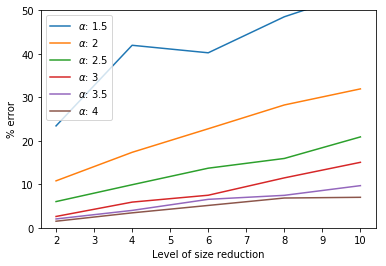

In [70]:
plotSingleSpatialFieldViaCoarsening()

Note how similar this plot is to one of the inverse of Moran's $I$. Applying our approximation function of Moran's $I$ to a dataset will give quite an accurate measure of the error incurred when coarsening at various levels.

In [71]:
def plotSingleSpatialFieldsMoransI(size=360):
    alphas = [1.5, 2, 2.5, 3, 3.5, 4]
    levels = [2, 4, 6, 8, 10]
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testMoransIAndBeta, {"size": size, "alpha": alpha, "bandwidth": level})[0]
            line.append(1 - value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend([r"$\alpha$: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0, 1)
    matplotlib.pyplot.xlabel("Bandwidth")
    matplotlib.pyplot.ylabel(r"Inverse of Moran's $I$")
    matplotlib.pyplot.savefig("Results/plotSingleSpatialFieldsMoransI.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

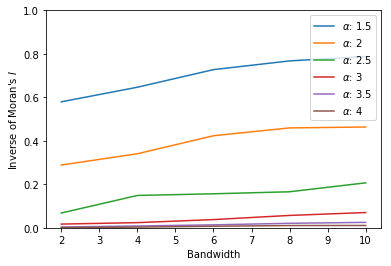

In [72]:
plotSingleSpatialFieldsMoransI()

Let's also plot the information loss as a function of the coarsening level for various _modes_.

In [73]:
def plotSingleSpatialFieldViaCoarseningModes(size=360, alpha=3):
    modesList = numpy.arange(1, 13.1, 3, dtype=int)
    levels = [2, 4, 6, 8, 10]
    for modes in modesList:
        line = []
        for level in levels:
            value = loop(testSingleSpatialFieldViaCoarsening, {"size": size, "alpha": alpha, "level": level, "modes": modes})
            line.append(100 * value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend(["modes: " + str(modes) for modes in modesList])
    matplotlib.pyplot.xlabel("Level of size reduction")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotSingleSpatialFieldViaCoarseningModes.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

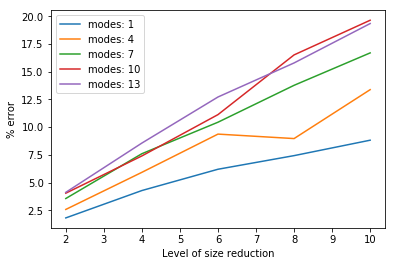

In [74]:
plotSingleSpatialFieldViaCoarseningModes()

In [75]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Spatial Coarsening

In the analysis of spatio-temporal fields, the spatial part of each time period can be coarsened. The _coarsenMatrix3D_ function simply loops over the temporal dimension and coarsens the spatial part.

In [76]:
def coarsenMatrix3D(array, level):
    h, w, d = array.shape
    coarsenedMatrix3D = numpy.empty((h // level, w // level, d))
    for i in range(d):
        coarsenedMatrix3D[:, :, i] = coarsenMatrix(array[:, :, i], level)
    return coarsenedMatrix3D

In a _CCA_ or _MCA_, the spatio-temporal fields are flattened, scaled and multiplied to obtain the cross-correlation matrix. To be able to compare this result with the original calculation, we need to be able to undo the effect of coarsening for such a product matrix. The output of the coarsened _SVD_ can be uncoarsened directly. The _uncoarsenUSV_ function returns the _U_, _s_ and _V_ as if the coarsening had not occured. Note that the vectors should really also be re-normalised.

In [77]:
def uncoarsenUSV(U, s, Vt, level, height):
    h, w = U.shape
    UReconstructed = numpy.repeat(numpy.repeat(numpy.vsplit(U, h / height), level, axis=0).reshape(-1, w), level, axis=0) / level
    h, w = Vt.shape
    VtReconstructed = numpy.repeat(numpy.repeat(numpy.array(numpy.hsplit(Vt, w / height)).swapaxes(0, 1), level, axis=1).reshape(h, -1), level, axis=1) / level
    s = s * level**2
    return UReconstructed, s, VtReconstructed

To see the effect of spatio-temporal coarsening, let's generate a _Gaussian Random Field_ and plot it together with a coarsened version. To be able to compare the two matrices, they need to be of the same size. Therefore, we also uncoarsen the coarsened matrix. The difference with the original field is shown in a plot. To determine precisely how much information is lost during the coarsening, we should look at the variance of the datasets. The norm of the difference between the uncoarsened matrix and the original is the amount of information lost in the coarsening process.

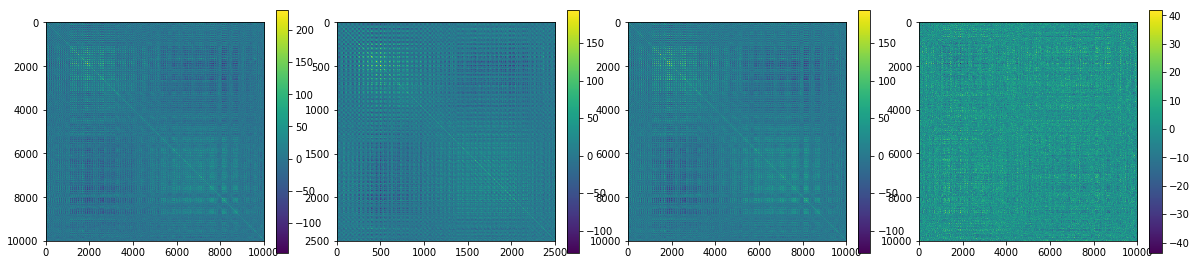

Norm original matrix: 179469.27193266698
Norm coarsened matrix: 43032.31046236628
Norm uncoarsened matrix: 172129.24184946305
Norm of their difference: 50801.020347725316
Percentage difference: 0.28306249755548557


In [78]:
spatialSize=100
temporalSize=60
alpha=3
level=2
matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
U1, s1, Vt1 = qrProductSVD(matrixFlattened1, matrixFlattened2)
reconstructedMatrix = usvToMatrix(U1, s1, Vt1)
matrixCombinedCoarsened = coarsenMatrix3D(matrixCombined, level)
matrixCoarsened1, matrixCoarsened2 = splitAndFlattenSpatialTemporalField(matrixCombinedCoarsened)
U2, s2, Vt2 = qrProductSVD(matrixCoarsened1, matrixCoarsened2)
reconstructedCoarsenedMatrix = usvToMatrix(U2, s2, Vt2)
U2, s2, Vt2 = uncoarsenUSV(U2, s2, Vt2, level, spatialSize // level)
reconstructedUncoarsenedMatrix = usvToMatrix(U2, s2, Vt2)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(reconstructedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(reconstructedCoarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(reconstructedUncoarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(reconstructedUncoarsenedMatrix - reconstructedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(reconstructedMatrix)
normDifference = scipy.linalg.norm(reconstructedMatrix - reconstructedUncoarsenedMatrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm coarsened matrix: " + str(scipy.linalg.norm(reconstructedCoarsenedMatrix)))
print("Norm uncoarsened matrix: " + str(scipy.linalg.norm(reconstructedUncoarsenedMatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testProductSpatialTemporalFieldsViaCoarsening_ function determines the percentage of the information lost in a coarsening process for matrices of various sizes and $\alpha$'s, and at various levels of coarsening. The two input matrices used here are similar, as they are generated by the same _Gaussian Random Process_. Therefore, they will correlate highly and the bases in which they are best described will be similar. In principle, any two datasets can be analysed and the amount of information lost during the coarsening process will likely depend on the similarity between the two datasets. This is one aspect which we do not cover here and leave for further research.

In [79]:
def testProductSpatialTemporalFieldsViaCoarsening(spatialSize=100, temporalSize=60, alpha=3, level=4, modes=8, highCor=True):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2 * temporalSize)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined, highCor)
    U1, s1, Vt1 = qrProductSVD(matrixFlattened1, matrixFlattened2)
    U1, s1, Vt1 = reduceUSV(U1, s1, Vt1, modes)
    matrixCombinedCoarsened = coarsenMatrix3D(matrixCombined, level)
    matrixCoarsened1, matrixCoarsened2 = splitAndFlattenSpatialTemporalField(matrixCombinedCoarsened, highCor)
    U2, s2, Vt2 = qrProductSVD(matrixCoarsened1, matrixCoarsened2)
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, modes)
    U2, s2, Vt2 = uncoarsenUSV(U2, s2, Vt2, level, spatialSize // level)
    return percentageNormDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2)

Due to the multiplication step in this analysis, the size of the cross-correlation matrix scales to the power $4$ of the coarsening level. Hence, typical error as a result of coarsening is larger than before.

In [80]:
loop(testProductSpatialTemporalFieldsViaCoarsening)

0.43089434349677924

One could vary both the spatial and the temporal size and examine the effect of the amount of information lost. For simplicity, we only vary the temporal size, which seems to not have a large effect.

In [81]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"temporalSize": 20})

0.47316805667031137

In [82]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"temporalSize": 100})

0.4316377004168653

As before, $\alpha$ plays an important part, with larger $\alpha$'s leading to less error after coarsening.

In [83]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"alpha": 1})

0.9954813520292106

In [84]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"alpha": 5})

0.12915596895410578

The result of varying the level of coarsening is shown below. It is substantial.

In [85]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"level": 2})

0.27863310666052776

In [86]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"level": 10})

0.6713555898967012

Finally, we can again examine the effect of taking into account more or fewer modes.

In [87]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"modes": 4})

0.38762015393762583

In [88]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"modes": 16})

0.4648244286491214

The amount of error likely also depends on the similarity between the two datasets. Though we leave deeper investigation of this aspect for further research, the following result does suggest the error increases for less similar input fields.

In [89]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"highCor": False})

0.43949872794299216

Let's plot the information loss as a function of the coarsening level for various $\alpha$'s. The spatial size is set to a common mutiple of the levels, so that coarsening is straightforward.

In [90]:
def plotProductSpatialTemporalFieldsViaCoarsening(modes=8):
    alphas = [1.5, 2, 2.5, 3, 3.5, 4]
    levels = [2, 3, 4, 6, 7, 8]
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testProductSpatialTemporalFieldsViaCoarsening, {"spatialSize": 168, "alpha": alpha, "level": level, "modes": modes})
            line.append(100 * value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend([r"$\alpha$: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0, 105)
    matplotlib.pyplot.xlabel("Level of size reduction")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotProductSpatialTemporalFieldsViaCoarsening.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

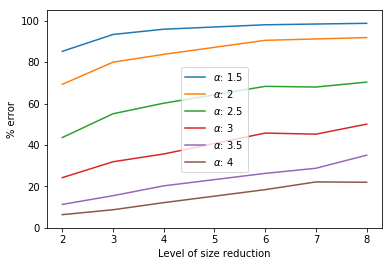

In [91]:
plotProductSpatialTemporalFieldsViaCoarsening()

In [92]:
_ = gc.collect()

### Efficient Approximate SVD via Dimensionality Reduction

The spatial coarsening process is intuitive and easy to implement. It is not, however, the most efficient way to reduce the size of a dataset. Dimensionality reduction refers to discarding modes which contribute little to the variance in a dataset. An _SVD_ is precisely the procedure used to find modes which explain as much variance as possible. Discarding the smallest singular values/vectors is, therefore, the most efficient form of dimensionality reduction [6]. Performing an _SVD_ on a large dataset, especially when it is stored out-of-core, is computationally costly. The Randomised Dimensionality Reduction process is far more efficient [9, 11, 12].

#### Single Spatial Field via Randomised Dimensionality Reduction

The _reduceSizeRandomisedSquare_ function reduces the input matrix to a smaller square matrix of _l_ by _l_. It also gives two projection matrices which can bring the rows and columns of this smaller matrix back to the bases of the original input. To make the result more precise, the procedure can be repeated multiple times. The parameter _i_ indicates how many iterations are performed.

In [93]:
def reduceSizeRandomisedSquare(A, i, l):
    # Based on [11]
    h, w = A.shape
    AW = A @ numpy.random.normal(0, 1, (w, l))
    H, RH = scipy.linalg.qr(AW, mode = "economic")
    ATH = A.T @ H
    W, RW = scipy.linalg.qr(ATH, mode = "economic")
    for _ in range(i):
        AW = A @ W
        H, RH = scipy.linalg.qr(AW, mode = "economic")
        ATH = A.T @ H
        W, RW = scipy.linalg.qr(ATH, mode = "economic")
    L = H.T @ A @ W
    return H, L, W

The _reconstructSquareRandomisedSizeReducedMatrix_ function can take the output of the previous function and approximately reconstruct the original matrix.

In [94]:
def reconstructSquareRandomisedSizeReducedMatrix(H, L, W):
    return H @ L @ W.T

The figure below shows that the SVD is not performed on the large matrix, but on its smaller approximation.

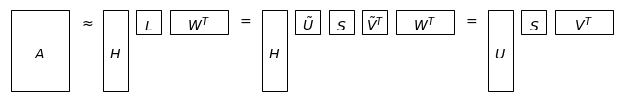

In [95]:
matrixDescription = [
    {"type":"Matrix", "width":0.7, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Symbol", "symbol":r"$\approx$"},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$L_{}^{}$"},
    {"type":"Matrix", "width":0.7, "height":0.3, "text":r"$W_{}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{U}_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{V}_{}^{T}$"},
    {"type":"Matrix", "width":0.7, "height":0.3, "text":r"$W_{}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$U_{}^{}}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{}^{}$"},
    {"type":"Matrix", "width":0.7, "height":0.3, "text":r"$V_{}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/reduceSizeRandomisedSquare.pdf")

To see the effect of dimensionality reduction, let's generate a _Gaussian Random Field_ and plot it together with a reduced version. To determine precisely how much information is lost during the reduction, we should look at the variance of the datasets. The norm of the difference between the reduced matrix and the original relates to the amount of information lost in the reduction process.

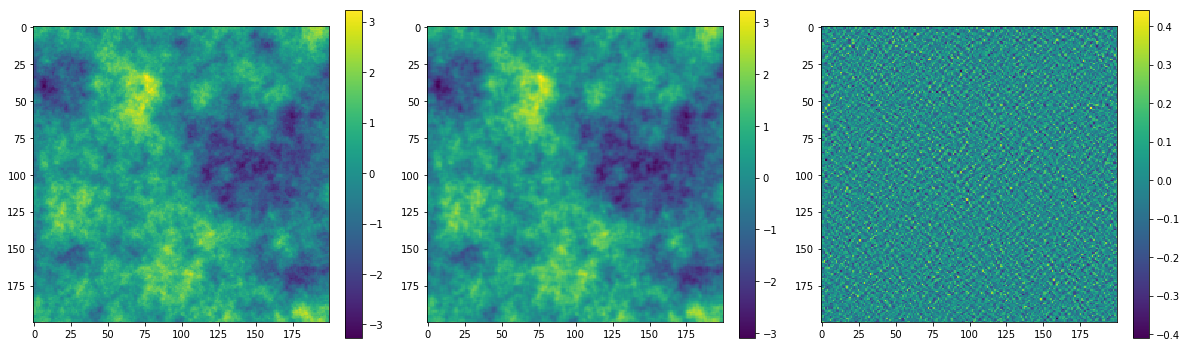

Norm original matrix: 200.00000000000003
Norm reduced matrix: 199.00520026632353
Norm of their difference: 19.923108867856364
Percentage difference: 0.0996155443392818


In [96]:
size = 200
alpha = 3
level = 4
i = 2
matrix = gaussianRandomSpatialField(alpha, size)
H, L, W = reduceSizeRandomisedSquare(matrix, i, size // level)
reconstructedmatrix = reconstructSquareRandomisedSizeReducedMatrix(H, L, W)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(reconstructedmatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(reconstructedmatrix - matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(matrix)
normDifference = scipy.linalg.norm(reconstructedmatrix - matrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm reduced matrix: " + str(scipy.linalg.norm(reconstructedmatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testRandomisedSizeReducedMatrix_ function determines the percentage of the information lost in a reduction process for matrices of various sizes and $\alpha$'s, and at various levels of reduction.

In [97]:
def testRandomisedSizeReducedMatrix(size=200, alpha=3, level=4, i=2, modes=4):
    matrix = gaussianRandomSpatialField(alpha, size)
    matrixReduced = reduceMatrix(matrix, modes)
    H, L, W = reduceSizeRandomisedSquare(matrix, i, size // level)
    LReduced = reduceMatrix(L, modes)
    reconstructedmatrix = reconstructSquareRandomisedSizeReducedMatrix(H, LReduced, W)
    return scipy.linalg.norm(reconstructedmatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

It is possible for some fields to be represented by matrices of much smaller sizes without losing any substantial amount of information. This makes sense when one realises the singular modes which are removed during the reduction are the smallest ones, described by the tail-end of the power law.

In [98]:
loop(testRandomisedSizeReducedMatrix)

4.6381549016436365e-07

As with Moran's $I$ and the coarsening, there is a substantial effect of size. We will not explore this further.

In [99]:
loop(testRandomisedSizeReducedMatrix, {"size": 100})

1.499633375445184e-05

In [100]:
loop(testRandomisedSizeReducedMatrix, {"size": 400})

1.3706803272299449e-08

The tail-end of a power law with a less negative exponent is larger, so the information lost during the reduction of such a field is larger too.

In [101]:
loop(testRandomisedSizeReducedMatrix, {"alpha": 1})

0.03948524912890096

In [102]:
loop(testRandomisedSizeReducedMatrix, {"alpha": 5})

1.5481983772663486e-13

Clearly, the level of reduction is important.

In [103]:
loop(testRandomisedSizeReducedMatrix, {"level": 2})

4.221904667149408e-09

In [104]:
loop(testRandomisedSizeReducedMatrix, {"level": 8})

1.3230792370237654e-05

As mentioned, the randomised reduction algorithm includes a loop which makes the projections to lower dimensions more precise. The effect, especially from 0 to 2, seems to be large.

In [105]:
loop(testRandomisedSizeReducedMatrix, {"i": 0})

0.03571901577694264

In [106]:
loop(testRandomisedSizeReducedMatrix, {"i": 4})

6.937986666099245e-12

In the review article by Halko, Martinsson and Tropp on randomised dimensionality reduction, it is suggested to oversample the reduction [9]. This is because the error introduced in the process is of the same order as the size of the last sampled singular value. If one is interested in the _k_ dominant modes, reducing to a _k + l_, for some small _l_, rank approximation will ensure the first _k_ modes are approximated quite well. Indeed, as seen below, the more modes one is interested in, the larger the difference compared with the original matrix.

In [107]:
loop(testRandomisedSizeReducedMatrix, {"modes": 2})

1.881107877260855e-08

In [108]:
loop(testRandomisedSizeReducedMatrix, {"modes": 8})

5.927899941502224e-06

In [109]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Randomised Dimensionality Reduction

The Randomised Dimensionality Reduction process can also be applied to the _CCA_ or _MCA_ analysis of two spatio-temporal fields. Similar to the _QR Product SVD_, it has the advantage that the _SVD_ is applied to a small _l_ by _l_ matrix. The result will be an approximation, but, as we will see, can be close to the real solution.

In [110]:
def randomisedSquareProductSVD(A1, A2, i, l):
    H1, L1, W1 = reduceSizeRandomisedSquare(A1, i, l)
    H2, L2, W2 = reduceSizeRandomisedSquare(A2, i, l)
    C = L1 @ W1.T @ W2 @ L2.T
    UC, s, VCt = scipy.linalg.svd(C, full_matrices = False)
    U = H1 @ UC
    Vt = VCt @ H2.T
    return U, s, Vt

The figure below depicts the calculation. Note that the large, rank deficient matrix product is never formed. The _SVD_ is performed on the smaller _l_ by _l_ matrix.

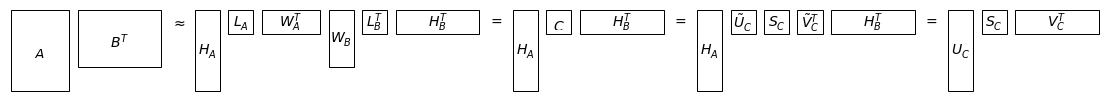

In [111]:
matrixDescription = [
    {"type":"Matrix", "width":0.7, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.7, "text":r"$B_{}^{T}$"},
    {"type":"Symbol", "symbol":r"$\approx$"},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$L_{A}^{}$"},
    {"type":"Matrix", "width":0.7, "height":0.3, "text":r"$W_{A}^{T}$"},
    {"type":"Matrix", "width":0.3, "height":0.7, "text":r"$W_{B}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$L_{B}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$H_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$C_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$H_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{U}_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{V}_{C}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$H_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$U_{C}^{}}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$V_{C}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/randomisedSquareProductSVD.pdf")

To see the effect of dimensionality reduction on such a matrix product, let's generate two _Gaussian Random Fields_ and plot their cross-correlation matrix together with a reduced version. To determine precisely how much information is lost during the reduction, we should look at the variance of the datasets. The norm of the difference between the reduced matrix and the original is the amount of information lost in the reduction process.

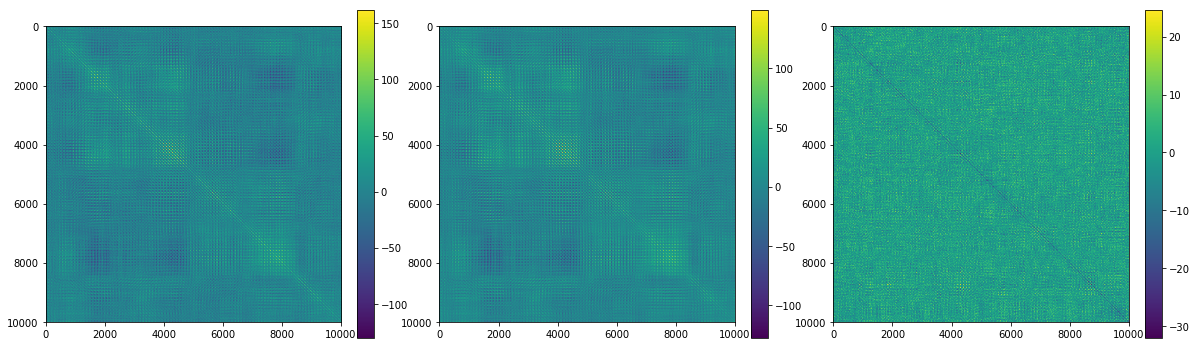

Norm original matrix: 156763.0766467004
Norm reconstructed matrix: 153220.52577852408
Norm of their difference: 33138.08503658662
Percentage difference: 0.21138960618430883


In [112]:
spatialSize=100
temporalSize=60
alpha=3
level=4
i=2
matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
reducedMatrix = usvToMatrix(U, s, Vt)
U, s, Vt = randomisedSquareProductSVD(matrixFlattened1, matrixFlattened2, i, int(temporalSize / level))
reconstructedMatrix = usvToMatrix(U, s, Vt)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(reducedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(reconstructedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(reconstructedMatrix - reducedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(reducedMatrix)
normDifference = scipy.linalg.norm(reconstructedMatrix - reducedMatrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm reconstructed matrix: " + str(scipy.linalg.norm(reconstructedMatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testRandomisedSizeReducedMatrixProduct_ function determines the percentage error in a reduction process for matrices of various sizes and $\alpha$'s, and at various levels of reduction. The two input matrices used here are similar, as they are generated by the same _Gaussian Random Process_. Therefore, they will correlate highly and the bases in which they are best described will be similar. In principle, any two datasets can be analysed and the amount of information lost during the coarsening process will likely depend on the similarity between the two datasets. This is one aspect which we do not cover here and leave for further research.

In [113]:
def testRandomisedSizeReducedMatrixProduct(spatialSize=100, temporalSize=60, alpha=3, level=4, i=2, modes=8, highCor=True):
    l = int(temporalSize / level)
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2 * temporalSize)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined, highCor)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    U, s, Vt = reduceUSV(U, s, Vt, min(modes, l))
    U2, s2, Vt2 = randomisedSquareProductSVD(matrixFlattened1, matrixFlattened2, i, l)
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, min(modes, l))
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s2, Vt2)

Due to the multiplication step in this analysis, the typical error as a result of reduction is larger than before.

In [114]:
loop(testRandomisedSizeReducedMatrixProduct)

0.04757404330025233

There is an affect of temporal size on the error. The _randomisedSquareProductSVD_ function is especially useful for square input matrices. To be able to do the comparisons with the full _SVD_ quickly, we use rectangular matrices here. The larger the temporal size, the more square the input matrices.

In [115]:
loop(testRandomisedSizeReducedMatrixProduct, {"temporalSize": 20})

0.27737315608768853

In [116]:
loop(testRandomisedSizeReducedMatrixProduct, {"temporalSize": 100})

0.012063026715769398

As before, the scale of the structure of the field influences the information loss. The effect in this case can be quite dramatic. Especially for larger $\alpha$, this procedure performs much better than the coarsening procedure.

In [117]:
loop(testRandomisedSizeReducedMatrixProduct, {"alpha": 1})

1.0541179845602169

In [118]:
loop(testRandomisedSizeReducedMatrixProduct, {"alpha": 5})

0.00023148827726385463

The level of reduction refers to the portion of the temporal size which is kept. Obviously, highly level reductions leads to worse results.

In [119]:
loop(testRandomisedSizeReducedMatrixProduct, {"level": 2})

0.013363048074141723

In [120]:
loop(testRandomisedSizeReducedMatrixProduct, {"level": 8})

0.18445273370207144

Again, the number of iterations of the randomised dimensionality reduction procedure can influence the results substantially.

In [121]:
loop(testRandomisedSizeReducedMatrixProduct, {"i": 0})

0.5932173216820783

In [122]:
loop(testRandomisedSizeReducedMatrixProduct, {"i": 4})

0.022479984685932604

The number of modes of interest also affect the resulting error.

In [123]:
loop(testRandomisedSizeReducedMatrixProduct, {"modes": 4})

0.02214928900151282

In [124]:
loop(testRandomisedSizeReducedMatrixProduct, {"modes": 16})

0.14460004574694843

The amount of error likely also depends on the similarity between the two datasets. Though we leave deeper investigation of this aspect for further research, the following result does suggest the error is effected by the similarity of the input fields. Unlike for coarsening, the error actually decreases.

In [125]:
loop(testRandomisedSizeReducedMatrixProduct, {"highCor": False})

0.028511729793444584

Let's plot the error as a function of the reduction level for various $\alpha$'s. Remember that, for two independently drawn _Gaussian Random Fields_, their difference is around 141% on average (related to the $\sqrt2$), so errors can be above 100%.

In [126]:
def plotRandomisedSizeReducedMatrixProduct(modes=8):
    alphas = [1.5, 2, 2.5, 3, 3.5, 4]
    levels = [2, 3, 4, 6, 7, 8]
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testRandomisedSizeReducedMatrixProduct, {"alpha": alpha, "level": level, "modes": modes})
            line.append(100 * value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend([r"$\alpha$: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0, 100)
    matplotlib.pyplot.xlabel("Level of size reduction")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotRandomisedSizeReducedMatrixProduct.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

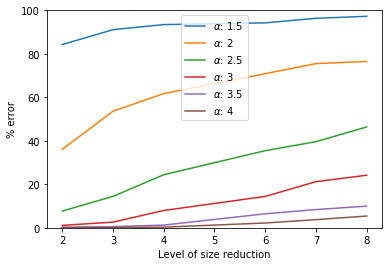

In [127]:
plotRandomisedSizeReducedMatrixProduct()

In [128]:
_ = gc.collect()

## Real-World Applications: Phenology

The following section will apply the same techniques to real datasets. In this section, we will examine the extended spring indices and the AVHRR start of season phenometric [17, 18, 19].

### Dataset Preperation

The following functions are used to plot the fields, taking into account their original 3D shape.

In [129]:
def structureMatrix(dataVector, maskFlattened, maskShape):
    structuredMatrix = numpy.full(maskShape[0] * maskShape[1], numpy.nan, dtype=numpy.float64)
    structuredMatrix[maskFlattened] = dataVector
    structuredMatrix = structuredMatrix.reshape(maskShape)
    return structuredMatrix

In [130]:
def structureMatrix3D(dataVectors, maskFlattened, maskShape):
    return numpy.array([structureMatrix(spatial, maskFlattened, maskShape) for spatial in dataVectors.swapaxes(0,1)]).swapaxes(0,2).swapaxes(0,1)

In [131]:
def plotStructuredMatrix(structuredMatrix, filePath = None):
    matplotlib.pyplot.imshow(structuredMatrix, aspect="auto")
    matplotlib.pyplot.colorbar()
    if filePath is not None:
        matplotlib.pyplot.savefig(filePath)
    matplotlib.pyplot.show()

In [132]:
def plotMatrix(dataVector, maskFlattened, maskShape, filePath = None):
    structuredMatrix = structureMatrix(dataVector, maskFlattened, maskShape)
    plotStructuredMatrix(structuredMatrix, filePath)

We load the data from compressed numpy files. This includes a mask which describes the boundary of the USA. The value of the fields over the ocean is NaN.

In [133]:
maskFlattened = numpy.load("Data/SIxAVHRR.npz")["maskFlattened"]
maskShape = numpy.load("Data/SIxAVHRR.npz")["maskShape"]
dataSetBloom = numpy.load("Data/SIxAVHRR.npz")["dataSetBloom"]
dataSetSos = numpy.load("Data/SIxAVHRR.npz")["dataSetSos"]

In [134]:
dataSetBloomFiltered = dataSetBloom[maskFlattened]

In [135]:
dataSetSosFiltered = dataSetSos[maskFlattened]

In [ ]:
dataSetBloomScaled = centerAndStandardiseField(dataSetBloomFiltered)

In [ ]:
dataSetSosScaled = centerAndStandardiseField(dataSetSosFiltered)

The datasets include some missing values, even over the land surface. We will not spend time imputing these in a fancy way, but simply add some reasonable random values. For the cross-correlation analysis, we need to scale the datasets.

In [136]:
meanBloom = numpy.nanmean(dataSetBloomFiltered)
stdBloom = numpy.nanstd(dataSetBloomFiltered)
nansBloom = numpy.isnan(dataSetBloomFiltered)
numberOfNaNsBloom = numpy.count_nonzero(nansBloom)
imputedValuesBloom = numpy.random.normal(meanBloom, stdBloom, numberOfNaNsBloom)
dataSetBloomImputed = numpy.copy(dataSetBloomFiltered)
dataSetBloomImputed[nansBloom] = imputedValuesBloom

In [137]:
meanSos = numpy.nanmean(dataSetSosFiltered)
stdSos = numpy.nanstd(dataSetSosFiltered)
nansSos = numpy.isnan(dataSetSosFiltered)
numberOfNaNsSos = numpy.count_nonzero(nansSos)
imputedValuesSos = numpy.random.normal(meanSos, stdSos, numberOfNaNsSos)
dataSetSosImputed = numpy.copy(dataSetSosFiltered)
dataSetSosImputed[nansSos] = imputedValuesSos

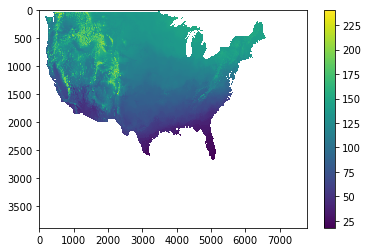

In [140]:
plotMatrix(dataSetBloomImputed[:, 0], maskFlattened, maskShape)

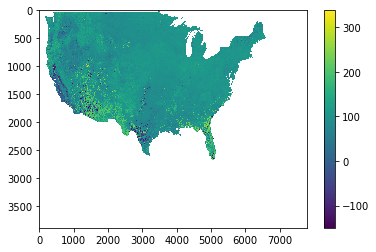

In [141]:
plotMatrix(dataSetSosImputed[:, 0], maskFlattened, maskShape)

In order to run our techniques for single fields (so without the time component), let's take the first time period. Let's also zoom in on a patch of the USA which is square and which does not include any missing values from the ocean areas. Although it won't give a precise measure, this patch will also be used to estimate the level of autocorrelation in the data.

In [142]:
structuredMatrixBloom = structureMatrix(dataSetBloomImputed[:, 0], maskFlattened, maskShape)
squareSubMatrixBloom = structuredMatrixBloom[900:1900, 1500:2500]

In [143]:
structuredMatrixSos = structureMatrix(dataSetSosImputed[:, 0], maskFlattened, maskShape)
squareSubMatrixSos = structuredMatrixSos[900:1900, 1500:2500]

Estimated Alpha: 2.755 | r^2: 0.530
Estimated Beta: 3.572 | r^2: 0.875
Moran's I: 0.970


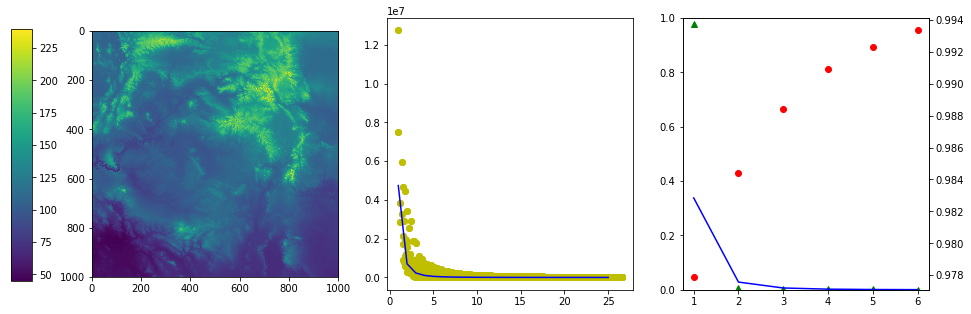

In [144]:
data = squareSubMatrixBloom
size = 1000
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
mi = approximateMoransI(data, bandwidth=10)
print("Moran's I: {:0.3f}".format(mi))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked, fftMasked, "yo")
ax2.plot(range(1, int(numpy.max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, int(numpy.max(wavesMasked))), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

Estimated Alpha: 1.215 | r^2: 0.185
Estimated Beta: 1.615 | r^2: 0.751
Moran's I: 0.371


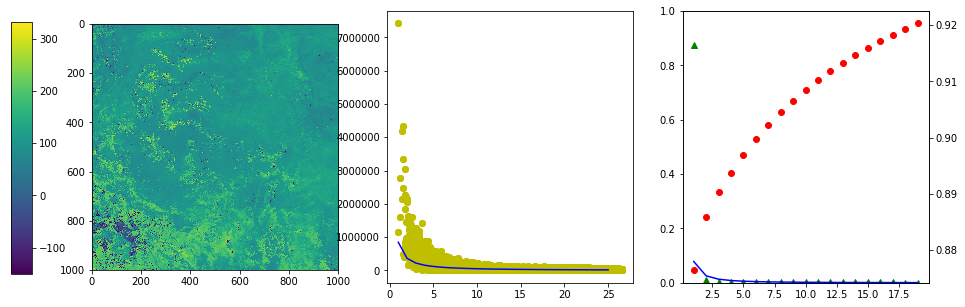

In [145]:
data = squareSubMatrixSos
size = 1000
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
mi = approximateMoransI(data, bandwidth=10)
print("Moran's I: {:0.3f}".format(mi))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked, fftMasked, "yo")
ax2.plot(range(1, int(numpy.max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, int(numpy.max(wavesMasked))), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

In [146]:
_ = gc.collect()

### Efficient SVD via Spatial Coarsening

In this section, the single time period will be coarsened and decomposed.

#### Single Spatial Field via Spatial Coarsening

The following function takes the input matrix, coarsens it and compares the SVD results.

In [147]:
def calculateSingleSpatialFieldViaCoarsening(matrix, level=4, modes=4):
    coarsenedMatrix = coarsenMatrix(matrix, level)
    coarsenedMatrixReduced = reduceMatrix(coarsenedMatrix, modes)
    uncoarsenedMatrix = uncoarsenMatrix(coarsenedMatrixReduced, level)
    matrixReduced = reduceMatrix(matrix, modes)
    return scipy.linalg.norm(uncoarsenedMatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

The Bloom extended Spring Index showed very high levels of autocorrelation. Our analysis of coarsening applied to _Gaussian Random Fields_ showed that autocorrelations between $2$ and $3$ resulted in errors between 3% and 15%. In fact, the performance here seems to be substantially better than that.

In [148]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom)

0.006109500646129436

As before, changing the level of coarsening affects the performance.

In [149]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, level=2)

0.002978478120548883

In [150]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, level=8)

0.011483692748974358

Also the number of modes of interest affects how large the error is.

In [151]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, modes=2)

0.004444908432042166

In [152]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, modes=8)

0.00863672323421509

Compared with the Bloom data, the Start-of-Season field has quite low autocorrelation. Based on the plot and on the $R^2$, we can see that the estimation of $\alpha$ is not very accurate. Perhaps Moran's $I$ gives a better indication of the level of autocorrelation. Either way, the amount of error due to coarsening is higher than for the Bloom data, but still not very substantial.

In [153]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos)

0.03872473384482027

As before, changing the level of coarsening affects the performance.

In [154]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, level=2)

0.025865316508937527

In [155]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, level=8)

0.0643967256794318

Also the number of modes of interest affects how large the error is.

In [156]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, modes=2)

0.02503034473159651

In [157]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, modes=8)

0.053775169996096675

In [158]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Spatial Coarsening

The following functions coarsen the input matrices, perform an SVD on their cross-correlation matrix and compare the results.

In [249]:
def uncoarsenMatrix3D(array, level):
    h, w, d = array.shape
    uncoarsenedMatrix3D = numpy.empty((h * level, w * level, d))
    for i in range(d):
        uncoarsenedMatrix3D[:, :, i] = uncoarsenMatrix(array[:, :, i], level)
    return uncoarsenedMatrix3D

In [250]:
def calculateProductSpatialTemporalFieldsViaCoarseningWithMask(matrix1, matrix2, maskFlattened, maskShape, level=4, modes=8):
    matrixScaled1 = centerAndStandardiseField(matrix1)
    matrixScaled2 = centerAndStandardiseField(matrix2)
    U, s, Vt = qrProductSVD(matrixScaled1, matrixScaled2)
    U, s, Vt = reduceUSV(U, s, Vt, modes)
    maskStructured = structureMatrix(maskFlattened[maskFlattened], maskFlattened, maskShape)
    maskCoarsened = ~numpy.isnan(coarsenMatrix(maskStructured, level)).flatten()
    matrixCoarsened1 = coarsenMatrix3D(structureMatrix3D(matrix1, maskFlattened, maskShape), level)
    matrixCoarsened2 = coarsenMatrix3D(structureMatrix3D(matrix2, maskFlattened, maskShape), level)
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrixCoarsened1, matrixCoarsened2)
    matrixMasked1 = matrixFlattened1[maskCoarsened]
    matrixMasked2 = matrixFlattened2[maskCoarsened]
    matrixMaskedScaled1 = centerAndStandardiseField(matrixMasked1)
    matrixMaskedScaled2 = centerAndStandardiseField(matrixMasked2)
    U2, s2, Vt2 = qrProductSVD(matrixMaskedScaled1, matrixMaskedScaled2)
    U2Restructured = structureMatrix3D(U2, maskCoarsened, (maskShape[0] // level, maskShape[1] // level))
    U2Uncoarsened = uncoarsenMatrix3D(U2Restructured, level)
    U2Uncoarsened = U2Uncoarsened.reshape(maskShape[0] * maskShape[1], U2Restructured.shape[2])[maskFlattened] / level
    V2Restructured = structureMatrix3D(Vt2.T, maskCoarsened, (maskShape[0] // level, maskShape[1] // level))
    V2Uncoarsened = uncoarsenMatrix3D(V2Restructured, level)
    V2Uncoarsened = V2Uncoarsened.reshape(maskShape[0] * maskShape[1], U2Restructured.shape[2])[maskFlattened] / level
    s2Uncoarsened = s2 * level**2
    U2, s2, Vt2 = reduceUSV(U2Uncoarsened, s2Uncoarsened, V2Uncoarsened.T, modes)
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s2, Vt2)

The analysis on coarsened spatio-temporal fields showed that autocorrelations between $2$ and $3$ resulted in errors between 20% and 80%. Although this is not a very precise prediction, the current datasets seem to conform to it. Note that standardisation occurs after coarsening.

In [251]:
calculateProductSpatialTemporalFieldsViaCoarseningWithMask(dataSetBloomImputed, dataSetSosImputed, maskFlattened, maskShape, level=4, modes=8)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


0.5939699092958963

In [256]:
_ = gc.collect()

Unfortunately, even with a low level of coarsening, the results are not great. Though they conform to our predictions.

In [257]:
calculateProductSpatialTemporalFieldsViaCoarseningWithMask(dataSetBloomImputed, dataSetSosImputed, maskFlattened, maskShape, level=2, modes=8)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


0.4708955881887499

In [258]:
_ = gc.collect()

The number of modes of interest does not have a large effect.

In [259]:
calculateProductSpatialTemporalFieldsViaCoarseningWithMask(dataSetBloomImputed, dataSetSosImputed, maskFlattened, maskShape, level=4, modes=4)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


0.5731151079194693

In [260]:
_ = gc.collect()

### Efficient SVD via Randomised Dimensionality Reduction

In this section, the single time period will be decomposed using the random algorithm.

#### Single Spatial Field via Randomised Dimensionality Reduction

The _calculateRandomisedSizeReducedMatrix_ function takes a matrix, performs the decomposition and compares the result.

In [167]:
def calculateRandomisedSizeReducedMatrix(matrix, level=4, i=2, modes=8):
    H, L, W = reduceSizeRandomisedSquare(matrix, i, matrix.shape[0] // level)
    LReduced = reduceMatrix(L, modes)
    reconstructedmatrix = reconstructSquareRandomisedSizeReducedMatrix(H, LReduced, W)
    matrixReduced = reduceMatrix(matrix, modes)
    return scipy.linalg.norm(reconstructedmatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

As expected from our previous analyses, the error is negligible.

In [168]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom)

6.574901461904263e-10

Changing the level of reduction affects the error somewhat, though it remains small.

In [169]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, level=2)

6.556484427139057e-12

In [170]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, level=8)

2.8773634942489973e-08

The number of iterations in our random algorithm does have a substantial effect.

In [171]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, i=0)

0.0024817749684270182

In [172]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, i=4)

1.7294183006126397e-15

The number of modes on interest has little effect.

In [173]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, modes=4)

3.529779104755036e-11

In [174]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, modes=16)

1.2587720851229759e-08

The Start-of-season data has less autocorrelation and the results are slightly worse.

In [175]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos)

3.027057824748969e-05

Again, some effect of the level of reduction.

In [176]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, level=2)

7.385339634188306e-07

In [177]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, level=8)

0.0002954712099209941

The effect of the number of iterations is quite large.

In [178]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, i=0)

0.03311438080793928

In [179]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, i=4)

4.1080178399816775e-08

The number of modes of interest has little effect.

In [180]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, modes=4)

9.233169753366062e-06

In [181]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, modes=16)

0.00013998280440108494

Let's collect garbage to keep our _Jupyter Notebook_ running smoothly.

In [182]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Randomised Dimensionality Reduction

In this section, we will reduce two datasets, perform an SVD on their cross-correlation matrix and then compare the results.

In [183]:
def calculateRandomisedSizeReducedMatrixProduct(matrixScaled1, matrixScaled2, level=4, i=2, modes=8):
    _, d = matrixScaled1.shape
    U, s, Vt = qrProductSVD(matrixScaled1, matrixScaled2)
    U, s, Vt = reduceUSV(U, s, Vt, min(modes, int(d / level)))
    U2, s2, Vt2 = randomisedSquareProductSVD(matrixScaled1, matrixScaled2, i, int(d / level))
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, min(modes, int(d / level)))
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s2, Vt2)

For datasets with an $\alpha$ between $2$ and $3$, our previous analysis shows that we can expect an error between 0% and 60%. However, this assumed that the autocorrelation in the temporal direction was similar to that in the spatial directions. This is important because the _Randomised Product SVD_ algorithm works on the spatially flattened matrix. If there is no autocorrelation in the temporal direction, the spatially flattened matrix cannot be reduced successfully. The following use case shows this clearly. The phenology data has been standardised by row, removing the mean of each time series. This removed the large scale structure in the data, decreasing both the spatial and the temporal autocorrelation substantially. The following results are not good.

In [184]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled)

0.5778880685161204

In [185]:
_ = gc.collect()

Our previous analysis suggests higher levels of reduction increase the error.

In [186]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, level=3)

0.4805026101485752

In [187]:
_ = gc.collect()

In [188]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, level=8)

0.5589688284384404

In [189]:
_ = gc.collect()

Having fewer iterations worsens the result, while more iterations dhepls slightly.

In [190]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, i=0)

0.8955943453931827

In [191]:
_ = gc.collect()

In [192]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, i=4)

0.474343214214402

In [193]:
_ = gc.collect()

The effect of the modes is small.

In [194]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, modes=4)

0.503799952936487

In [195]:
_ = gc.collect()

In [196]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, modes=16)

0.5330808180871733

In [197]:
_ = gc.collect()

## Real-World Applications: JRA-55

The following section will apply our dataset reduction techniques to global atmospheric energy data from JRA-55 [20, 21].

### Dataset Preperation

Let's first load the data and standardize each gridpoints' timeseries.

In [198]:
energyArray = numpy.load("Data/JRA55.npz")["energyArray"]

In [199]:
latentHeatArray = numpy.load("Data/JRA55.npz")["latentHeatArray"]

In [200]:
energyArrayScaled = centerAndStandardiseSpatioTemporalField(energyArray)

In [201]:
latentHeatArrayScaled = centerAndStandardiseSpatioTemporalField(latentHeatArray)

In [202]:
energyArrayFlattened, latentHeatArrayFlattened = flattenSpatialTemporalFields(energyArrayScaled, latentHeatArrayScaled)

By taking the first time period, we can get an impression of the spatial autocorrelation within the fields. The estimations of $\alpha$ do not seem to be reliable, but Moran's $I$ suggests fairly high levels of autocorrelation.

Estimated Alpha: 5.486 | r^2: 0.575
Estimated Beta: 2.488 | r^2: 0.908
Moran's I: 0.932


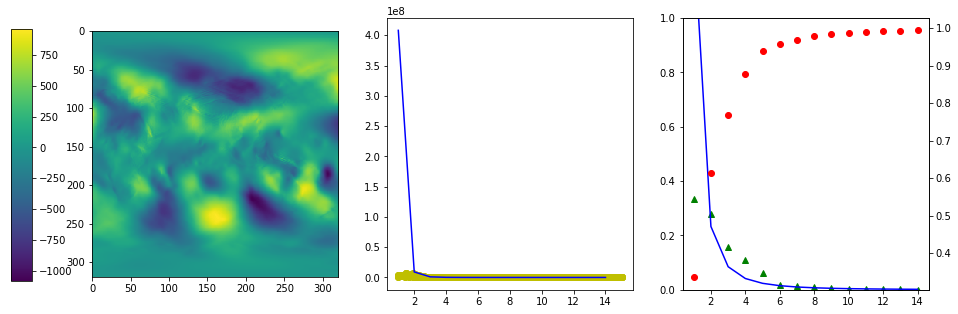

In [203]:
data = energyArray[:320, :320, 0]
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
mi = approximateMoransI(data, bandwidth=10)
print("Moran's I: {:0.3f}".format(mi))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked, fftMasked, "yo")
ax2.plot(range(1, int(max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, int(max(wavesMasked))), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

Estimated Alpha: 5.553 | r^2: 0.679
Estimated Beta: 2.276 | r^2: 0.975
Moran's I: 0.859


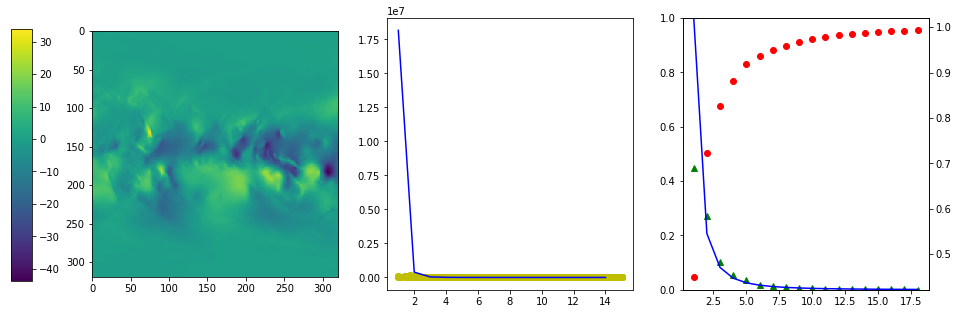

In [204]:
data = latentHeatArray[:320, :320, 0]
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
mi = approximateMoransI(data, bandwidth=10)
print("Moran's I: {:0.3f}".format(mi))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked, fftMasked, "yo")
ax2.plot(range(1, int(max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, int(max(wavesMasked))), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

### Efficient SVD via Spatial Coarsening

In this section, the single time period will be coarsened and decomposed.

#### Single Spatial Field via Spatial Coarsening

The JRA-55 energy array showed high levels of autocorrelation. Our analysis of coarsening applied to _Gaussian Random Fields_ suggests that autocorrelations around $\alpha=3$ result in errors around 5%. This prediction seems to be accurate.

In [205]:
calculateSingleSpatialFieldViaCoarsening(energyArray[:,:,0])

0.07729425

Coarsening at a level equal to $2$ would bring the error down to a few percent, while a level equal to $8$ would bring it closer to 10%. The JRA-55 energy data seem to behave according to this prediction.

In [206]:
calculateSingleSpatialFieldViaCoarsening(energyArray[:,:,0], level=2)

0.03454027

In [207]:
calculateSingleSpatialFieldViaCoarsening(energyArray[:,:,0], level=8)

0.15829687

Changing the modes of interest has little effect.

In [208]:
calculateSingleSpatialFieldViaCoarsening(energyArray[:,:,0], modes=2)

0.07052301

In [209]:
calculateSingleSpatialFieldViaCoarsening(energyArray[:,:,0], modes=8)

0.08484397

For _Gaussian Random Fields_ with an $\alpha=2.5$, our analysis predicts an error of around 10% after coarsening. The JRA-55 latent heat data seem to behave according to this prediction.

In [210]:
calculateSingleSpatialFieldViaCoarsening(latentHeatArray[:,:,0])

0.10623774

For coarsening levels of $2$ and $8$, the prediction ranges from 3% to 15%. The current dataset, although slightly higher, conforms largely to this prediction.

In [211]:
calculateSingleSpatialFieldViaCoarsening(latentHeatArray[:,:,0], level=2)

0.048168514

In [212]:
calculateSingleSpatialFieldViaCoarsening(latentHeatArray[:,:,0], level=8)

0.20988403

Again, the number of modes only has a minor effect. 

In [213]:
calculateSingleSpatialFieldViaCoarsening(latentHeatArray[:,:,0], modes=2)

0.0934414

In [214]:
calculateSingleSpatialFieldViaCoarsening(latentHeatArray[:,:,0], modes=8)

0.120431356

In [215]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Spatial Coarsening

The following function coarsens the input matrices, performs an SVD on their cross-correlation matrix and compares the results.

In [216]:
def calculateProductSpatialTemporalFieldsViaCoarsening(matrix1, matrix2, level=4, modes=8):
    h, w, d = matrix1.shape
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrix1, matrix2)
    U1, s1, Vt1 = qrProductSVD(matrixFlattened1, matrixFlattened2)
    U1, s1, Vt1 = reduceUSV(U1, s1, Vt1, modes)
    matrixCoarsened1 = coarsenMatrix3D(matrix1, level)
    matrixCoarsened2 = coarsenMatrix3D(matrix2, level)
    matrixCoarsenedFlattened1, matrixCoarsenedFlattened2 = flattenSpatialTemporalFields(matrixCoarsened1, matrixCoarsened2)
    U2, s2, Vt2 = qrProductSVD(matrixCoarsenedFlattened1, matrixCoarsenedFlattened2)
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, modes)
    U2, s2, Vt2 = uncoarsenUSV(U2, s2, Vt2, level, w // level)
    return percentageNormDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2)

The analysis on coarsened spatio-temporal fields showed that autocorrelations between $2.5$ and $3$ resulted in errors between 40% and 70%. Although this is not a very precise prediction, the current datasets clearly falls below this range. Perhaps _Gaussian Random Fields_ are not good representations of the JRA-55 datasets or there are other effects not taken into account by our method.

In [217]:
calculateProductSpatialTemporalFieldsViaCoarsening(energyArrayScaled, latentHeatArrayScaled, level=4, modes=8)

0.1557100544263451

In [218]:
_ = gc.collect()

As before, decreasing the level improves the results.

In [219]:
calculateProductSpatialTemporalFieldsViaCoarsening(energyArrayScaled, latentHeatArrayScaled, level=2, modes=8)

0.0794179448522178

In [220]:
_ = gc.collect()

Having fewer modes does not affect the results substantially.

In [221]:
calculateProductSpatialTemporalFieldsViaCoarsening(energyArrayScaled, latentHeatArrayScaled, level=4, modes=4)

0.15943717127667145

In [222]:
_ = gc.collect()

### Efficient SVD via Randomised Dimensionality Reduction

In this section, the single time period will be decomposed using the random algorithm.

#### Single Spatial Field via Randomised Dimensionality Reduction

As expected from our previous analyses, the error is negligible.

In [223]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0])

7.763923094743393e-06

Changing the level of reduction affects the error somewhat, though it remains small.

In [224]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0], level=2)

7.763923033328744e-06

In [225]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0], level=8)

7.765430356087461e-06

The number of iterations in our random algorithm does have a substantial effect.

In [226]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0], i=0)

0.006719121142612812

In [227]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0], i=4)

7.763923180709033e-06

The number of modes of interest has little effect.

In [228]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0], modes=4)

8.72345283297216e-07

In [229]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0], modes=16)

9.298637019345398e-07

The JRA-55 latent heat data has less autocorrelation and the results are slightly worse.

In [230]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0])

8.897097661303973e-07

Again, some effect of the level of reduction.

In [231]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0], level=2)

8.897128703428299e-07

In [232]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0], level=8)

1.1576762454876822e-06

The effect of the number of iterations is quite large.

In [233]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0], i=0)

0.007777388689230261

In [234]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0], i=4)

8.897128706550831e-07

The number of modes of interest has some, but only little effect.

In [235]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0], modes=4)

9.294575801235089e-07

In [236]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0], modes=16)

9.206703491958599e-07

Let's collect garbage to keep our _Jupyter Notebook_ running smoothly.

In [237]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Randomised Dimensionality Reduction

In this section, we will reduce two datasets, perform an SVD on their cross-correlation matrix and then compare the results.

For datasets with an $\alpha$ between $2.5$ and $3$, our previous analysis shows that we can expect an error between 5% and 25%. Although this prediction is not very precise, the JRA-55 data clearly falls below this range.

In [238]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened)

0.02346562910746956

In [239]:
_ = gc.collect()

Our previous analysis suggests a reduction level equal to $3$ should give errors between 3% and 20%, while a reduction level of $8$ gives errors between 10% and 80%. Our datasets fall below this range.

In [240]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened, level=3)

0.01768720703492592

In [241]:
_ = gc.collect()

In [242]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened, level=8)

0.04455090444455428

In [243]:
_ = gc.collect()

Having fewer iterations worsens the result substantially, while more iterations helps slightly.

In [244]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened, i=0)

0.23111376605140296

In [245]:
_ = gc.collect()

In [246]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened, i=4)

KeyboardInterrupt: 

In [ ]:
_ = gc.collect()

The effect of the modes is quite substantial in this case.

In [ ]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened, modes=4)

In [ ]:
_ = gc.collect()

In [ ]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened, modes=16)

In [ ]:
_ = gc.collect()

## Real-World Applications: ERA-5

The following section will apply the same techniques to global cloud an humidty data from ERA-5 [22].

### Dataset Preperation

Let's first load the data and standardize each gridpoints' timeseries.

In [ ]:
humidityArray = numpy.load("Data/ERA5.npz")["humidityArray"][:720,:720,:]

In [ ]:
cloudCoverArray = numpy.load("Data/ERA5.npz")["cloudCoverArray"][:720,:720,:]

In [ ]:
humidityArrayScaled = centerAndStandardiseSpatioTemporalField(humidityArray)

In [ ]:
cloudCoverArrayScaled = centerAndStandardiseSpatioTemporalField(cloudCoverArray)

In [ ]:
humidityArrayFlattened, cloudCoverArrayFlattened = flattenSpatialTemporalFields(humidityArrayScaled, cloudCoverArrayScaled)

By taking the first time period, we can get an impression of the spatial autocorrelation within the fields. The estimations of $\alpha$ do not seem to be reliable, but Moran's $I$ suggests fairly high levels of autocorrelation.

In [ ]:
data = humidityArray[:,:,0]
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
mi = approximateMoransI(data, bandwidth=10)
print("Moran's I: {:0.3f}".format(mi))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked, fftMasked, "yo")
ax2.plot(range(1, int(max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, int(max(wavesMasked))), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

In [ ]:
data = cloudCoverArray[:,:,0]
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
mi = approximateMoransI(data, bandwidth=10)
print("Moran's I: {:0.3f}".format(mi))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked, fftMasked, "yo")
ax2.plot(range(1, int(max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, int(max(wavesMasked))), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

### Efficient SVD via Spatial Coarsening

In this section, the single time period will be coarsened and decomposed.

#### Single Spatial Field via Spatial Coarsening

The ERA-5 humidity array showed high levels of autocorrelation. Our analysis of coarsening applied to Gaussian Random Fields suggests that autocorrelations around $\alpha=3.5$ result in errors below 5%. This prediction seems to be accurate.

In [ ]:
calculateSingleSpatialFieldViaCoarsening(humidityArray[:,:,0])

Coarsening at a level equal to $2$ would bring the error down to a few percent, while a level equal to $8$ would bring it closer to 10%. The errors of the  ERA-5 humidity data seem to be substantially below to this prediction.

In [ ]:
calculateSingleSpatialFieldViaCoarsening(humidityArray[:,:,0], level=2)

In [ ]:
calculateSingleSpatialFieldViaCoarsening(humidityArray[:,:,0], level=8)

Changing the modes of interest has little effect.

In [ ]:
calculateSingleSpatialFieldViaCoarsening(humidityArray[:,:,0], modes=2)

In [ ]:
calculateSingleSpatialFieldViaCoarsening(humidityArray[:,:,0], modes=8)

For Gaussian Random Fields with an $\alpha=2.5$, our analysis predicts an error of around 10% after coarsening. The ERA-5 cloud cover data seem to behave according to this prediction.

In [ ]:
calculateSingleSpatialFieldViaCoarsening(cloudCoverArray[:,:,0])

For coarsening levels of $2$ and $8$, the prediction ranges from 3% to 15%. The current dataset conforms nicely to this prediction.

In [ ]:
calculateSingleSpatialFieldViaCoarsening(cloudCoverArray[:,:,0], level=2)

In [ ]:
calculateSingleSpatialFieldViaCoarsening(cloudCoverArray[:,:,0], level=8)

Again, the number of modes only has a minor effect.

In [ ]:
calculateSingleSpatialFieldViaCoarsening(cloudCoverArray[:,:,0], modes=2)

In [ ]:
calculateSingleSpatialFieldViaCoarsening(cloudCoverArray[:,:,0], modes=8)

In [ ]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Spatial Coarsening

The analysis on coarsened spatio-temporal fields showed that autocorrelations between $2.5$ and $3.5$ resulted in errors between 30% and 70%. Although this is not a very precise prediction, the current datasets falls in the bottom of this range.

In [ ]:
calculateProductSpatialTemporalFieldsViaCoarsening(humidityArrayScaled, cloudCoverArrayScaled, level=4, modes=8)

In [ ]:
_ = gc.collect()

Using a coarseling level of $2$ changes the prediction to a range of 10% to 50%. Again, the results fall on the bottom end of this range.

In [ ]:
calculateProductSpatialTemporalFieldsViaCoarsening(humidityArrayScaled, cloudCoverArrayScaled, level=2, modes=8)

In [ ]:
_ = gc.collect()

Having fewer modes does not affect the results substantially.

In [ ]:
calculateProductSpatialTemporalFieldsViaCoarsening(humidityArrayScaled, cloudCoverArrayScaled, level=4, modes=4)

In [ ]:
_ = gc.collect()

### Efficient SVD via Randomised Dimensionality Reduction

In this section, the single time period will be decomposed using the random algorithm.

#### Single Spatial Field via Randomised Dimensionality Reduction

As expected from our previous analyses, the error is negligible.

In [ ]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0])

Changing the level of reduction affects the error somewhat, though it remains small.

In [ ]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0], level=2)

In [ ]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0], level=8)

The number of iterations in our random algorithm does have a substantial effect.

In [ ]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0], i=0)

In [ ]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0], i=4)

The number of modes of interest has little effect.

In [ ]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0], modes=4)

In [ ]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0], modes=16)

The ERA-5 cloud cover data has less autocorrelation and the results are slightly worse.

In [ ]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0])

Again, some effect of the level of reduction.

In [ ]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0], level=2)

In [ ]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0], level=8)

The effect of the number of iterations is quite large.

In [ ]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0], i=0)

In [ ]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0], i=4)

The number of modes of interest has some, but only little effect.

In [ ]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0], modes=4)

In [ ]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0], modes=16)

Let's collect garbage to keep our Jupyter Notebook running smoothly.

In [ ]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Randomised Dimensionality Reduction

In this section, we will reduce two datasets, perform an SVD on their cross-correlation matrix and then compare the results.

For datasets with an $\alpha$ between $2.5$ and $3.5$, our previous analysis shows that we can expect an error between 2% and 25%. Although this prediction is not very precise, the ERA-5 data fall in the range.

In [ ]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened)

In [ ]:
_ = gc.collect()

Our previous analysis suggests a reduction level equal to $3$ should give errors between 0% and 20%, while a reduction level of $8$ gives errors between 5% and 80%. Our datasets fall in the middle of this range.

In [ ]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened, level=3)

In [ ]:
_ = gc.collect()

In [ ]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened, level=8)

In [ ]:
_ = gc.collect()

Having fewer iterations worsens the result substantially, while more iterations helps.

In [ ]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened, i=0)

In [ ]:
_ = gc.collect()

In [ ]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened, i=4)

In [ ]:
_ = gc.collect()

The effect of the modes is quite substantial in this case.

In [ ]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened, modes=4)

In [ ]:
_ = gc.collect()

In [ ]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened, modes=16)

In [ ]:
_ = gc.collect()

## Unsuccessful Techniques

The following techniques related to SVD's were investigated but did not provide clear results. These sections are not documented well because they were not included in the final article [3].

### Noise Reduction via Pre-Filtering

The reduction of the number of dimensions of each input dataset is actually advised by some researchers, as a method to filter out noise [1]. Especially  when  the  number of temporal samples is small, outliers and random fluctuations could affect the result [4]. This is because any statistical analysis will choose its regression-coefficients so as to optimize the fit. It may occur that two noise-vectors in the two fields coincidentally covary and show up as dominant modes. Prefiltering can alleviate this risk.

#### Single Spatial Field

Text

In [ ]:
def addNoise(matrix, noiseLevel=1.0):
    return matrix + numpy.random.normal(loc=0.0, scale=noiseLevel, size=matrix.shape)

Text

In [ ]:
def testNoiseReduction(size=200, alpha=2, noiseScale=0.1, reduction=3):
    matrix = gaussianRandomSpatialField(alpha, size)
    noiseLevel = noiseScale * numpy.std(matrix)
    matrixNoise = addNoise(matrix, noiseLevel)
    matrixNoiseReduced = reduceMatrix(matrixNoise, size//reduction)
    normMatrix = scipy.linalg.norm(matrix)
    normDifferenceMatrixNoise = scipy.linalg.norm(matrix - matrixNoise)
    normDifferenceMatrixNoiseReduced = scipy.linalg.norm(matrix - matrixNoiseReduced)
    percentageNormDifference1 = normDifferenceMatrixNoise / normMatrix
    percentageNormDifference2 = normDifferenceMatrixNoiseReduced / normMatrix
    percentageNormDifference3 = normDifferenceMatrixNoiseReduced / normDifferenceMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [ ]:
loop(testNoiseReduction)

In [ ]:
loop(testNoiseReduction, {"size": 100})

In [ ]:
loop(testNoiseReduction, {"size": 400})

In [ ]:
loop(testNoiseReduction, {"alpha": 1})

In [ ]:
loop(testNoiseReduction, {"alpha": 4})

In [ ]:
loop(testNoiseReduction, {"noiseScale": 0.05})

In [ ]:
loop(testNoiseReduction, {"noiseScale": 0.5})

In [ ]:
loop(testNoiseReduction, {"reduction": 2})

In [ ]:
loop(testNoiseReduction, {"reduction": 4})

#### Product of Spatial Fields

Text

In [ ]:
def testNoiseReductionProduct(size=200, alpha=2, noiseScale=0.1, reduction=3, reconstruction=4):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, size, 2)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrix1 = matrixCombined[:, :, 0]
    matrix2 = matrixCombined[:, :, 1]
    productMatrix = matrix1 @ matrix2.T
    productMatrixReconstructed = reduceMatrix(productMatrix, size//reconstruction)
    matrixNoise1 = addNoise(matrix1, noiseLevel)
    matrixNoise2 = addNoise(matrix2, noiseLevel)
    productMatrixNoise = matrixNoise1 @ matrixNoise2.T
    productMatrixNoiseReconstructed = reduceMatrix(productMatrixNoise, size//reconstruction)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1, size//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2, size//reduction)
    productMatrixNoiseReduced = matrixNoiseReduced1 @ matrixNoiseReduced2.T    
    productMatrixNoiseReducedReconstructed = reduceMatrix(productMatrixNoiseReduced, size//reconstruction)
    normProductMatrix = scipy.linalg.norm(productMatrixReconstructed)
    normDifferenceProductMatrixNoise = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReconstructed)
    normDifferenceProductMatrixNoiseReduced = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReducedReconstructed)
    percentageNormDifference1 = normDifferenceProductMatrixNoise / normProductMatrix
    percentageNormDifference2 = normDifferenceProductMatrixNoiseReduced / normProductMatrix
    percentageNormDifference3 = normDifferenceProductMatrixNoiseReduced / normDifferenceProductMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [ ]:
loop(testNoiseReductionProduct)

In [ ]:
loop(testNoiseReductionProduct, {"size": 100})

In [ ]:
loop(testNoiseReductionProduct, {"size": 400})

In [ ]:
loop(testNoiseReductionProduct, {"alpha": 1})

In [ ]:
loop(testNoiseReductionProduct, {"alpha": 4})

In [ ]:
loop(testNoiseReductionProduct, {"noiseScale": 0.05})

In [ ]:
loop(testNoiseReductionProduct, {"noiseScale": 0.5})

In [ ]:
loop(testNoiseReductionProduct, {"reduction": 2})

In [ ]:
loop(testNoiseReductionProduct, {"reduction": 4})

In [ ]:
loop(testNoiseReductionProduct, {"reconstruction": 3})

In [ ]:
loop(testNoiseReductionProduct, {"reconstruction": 5})

#### Product of Spatial Fields with Correlated Noise

Text

In [ ]:
def addCorrelatedNoise3D(matrix, noiseLevel=1.0):
    noise = noiseLevel * gaussianRandomSpatialTemporalField(alpha/4, matrix.shape[0], matrix.shape[2])  
    return matrix + noise

Text

In [ ]:
def testNoiseReductionCorrelatedNoiseProduct(size=200, alpha=2, noiseScale=0.1, reduction=3, reconstruction=4):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, size, 2)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrixCombinedNoise = addCorrelatedNoise3D(matrixCombined, noiseLevel)
    matrix1, matrix2 = splitSpatialTemporalField(matrixCombined)
    matrixNoise1, matrixNoise2 = splitSpatialTemporalField(matrixCombinedNoise)
    productMatrix = matrix1[:, :, 0] @ matrix2[:, :, 0].T
    productMatrixReconstructed = reduceMatrix(productMatrix, size//reconstruction)
    productMatrixNoise = matrixNoise1[:, :, 0] @ matrixNoise2[:, :, 0].T
    productMatrixNoiseReconstructed = reduceMatrix(productMatrixNoise, size//reconstruction)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1[:, :, 0], size//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2[:, :, 0], size//reduction)
    productMatrixNoiseReduced = matrixNoiseReduced1 @ matrixNoiseReduced2.T    
    productMatrixNoiseReducedReconstructed = reduceMatrix(productMatrixNoiseReduced, size//reconstruction)
    normProductMatrix = scipy.linalg.norm(productMatrixReconstructed)
    normDifferenceProductMatrixNoise = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReconstructed)
    normDifferenceProductMatrixNoiseReduced = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReducedReconstructed)
    percentageNormDifference1 = normDifferenceProductMatrixNoise / normProductMatrix
    percentageNormDifference2 = normDifferenceProductMatrixNoiseReduced / normProductMatrix
    percentageNormDifference3 = normDifferenceProductMatrixNoiseReduced / normDifferenceProductMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct)

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"size": 100})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"size": 400})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"alpha": 1})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"alpha": 4})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"noiseScale": 0.05})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"noiseScale": 0.5})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reduction": 2})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reduction": 4})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reconstruction": 3})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reconstruction": 5})

#### Product of Spatio-Temporal Fields with Correlated Noise

Text

In [ ]:
def testNoiseReductionSpatialTemporalField(spatialSize=100, temporalSize=60, alpha=2, noiseScale=0.1, reduction=3, reconstruction=4):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrixCombinedNoise = addCorrelatedNoise3D(matrixCombined, noiseLevel)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    matrixNoise1, matrixNoise2 = splitAndFlattenSpatialTemporalField(matrixCombinedNoise)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1, temporalSize//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2, temporalSize//reduction)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    UNoise, sNoise, VtNoise = qrProductSVD(matrixNoise1, matrixNoise2)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = qrProductSVD(matrixNoiseReduced1, matrixNoiseReduced2)
    U, s, Vt = reduceUSV(U, s, Vt, temporalSize//reconstruction)
    UNoise, sNoise, VtNoise = reduceUSV(UNoise, sNoise, VtNoise, temporalSize//reconstruction)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = reduceUSV(UNoiseReduced, sNoiseReduced, VtNoiseReduced, temporalSize//reconstruction)
    percentageNormDifference1 = percentageNormDifferenceFromUSVs(U, s, Vt, UNoise, sNoise, VtNoise)
    percentageNormDifference2 = percentageNormDifferenceFromUSVs(U, s, Vt, UNoiseReduced, sNoiseReduced, VtNoiseReduced)
    percentageNormDifference3 = percentageNormDifferenceFromUSVs(UNoise, sNoise, VtNoise, UNoiseReduced, sNoiseReduced, VtNoiseReduced)
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [ ]:
loop(testNoiseReductionSpatialTemporalField)

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"temporalSize": 20})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"temporalSize": 100})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"alpha": 1})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"alpha": 4})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"noiseScale": 0.05})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"noiseScale": 0.5})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"reduction": 2})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"reduction": 4})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"reconstruction": 3})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"reconstruction": 5})

#### Product of Standardised Spatio-Temporal Fields with Correlated Noise

Text

In [ ]:
def testNoiseReductionSpatialTemporalFieldCorrelation(spatialSize=100, temporalSize=60, alpha=2, noiseScale=0.1, reduction=3, reconstruction=5):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrixCombinedNoise = addCorrelatedNoise3D(matrixCombined, noiseLevel)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    matrixScaled1 = centerAndStandardiseField(matrixFlattened1)
    matrixScaled2 = centerAndStandardiseField(matrixFlattened2)
    matrixNoise1, matrixNoise2 = splitAndFlattenSpatialTemporalField(matrixCombinedNoise)
    matrixNoiseScaled1 = centerAndStandardiseField(matrixNoise1)
    matrixNoiseScaled2 = centerAndStandardiseField(matrixNoise2)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1, temporalSize//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2, temporalSize//reduction)
    matrixNoiseReducedScaled1 = centerAndStandardiseField(matrixNoiseReduced1)
    matrixNoiseReducedScaled2 = centerAndStandardiseField(matrixNoiseReduced2)
    U, s, Vt = qrProductSVD(matrixScaled1, matrixScaled2)
    UNoise, sNoise, VtNoise = qrProductSVD(matrixNoiseScaled1, matrixNoiseScaled2)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = qrProductSVD(matrixNoiseReducedScaled1, matrixNoiseReducedScaled2)
    U, s, Vt = reduceUSV(U, s, Vt, temporalSize//reconstruction)
    UNoise, sNoise, VtNoise = reduceUSV(UNoise, sNoise, VtNoise, temporalSize//reconstruction)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = reduceUSV(UNoiseReduced, sNoiseReduced, VtNoiseReduced, temporalSize//reconstruction)
    percentageNormDifference1 = percentageNormDifferenceFromUSVs(U, s, Vt, UNoise, sNoise, VtNoise)
    percentageNormDifference2 = percentageNormDifferenceFromUSVs(U, s, Vt, UNoiseReduced, sNoiseReduced, VtNoiseReduced)
    percentageNormDifference3 = percentageNormDifferenceFromUSVs(UNoise, sNoise, VtNoise, UNoiseReduced, sNoiseReduced, VtNoiseReduced)
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation)

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"temporalSize": 20})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"temporalSize": 100})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"alpha": 1})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"alpha": 4})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"noiseScale": 0.05})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"noiseScale": 0.5})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reduction": 2})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reduction": 4})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reconstruction": 3})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reconstruction": 5})

### Efficient SVD via Grid Analysis

Text

#### Single Spatial Field via Single Grid

Text

We can use the _matrixToGrid_ function defined below to cut a field into multiple smaller sections. The _gridToMatrix_ function does the reverse operation and knits together multiple smaller matrices into one large matrix.

In [ ]:
def matrixToGrid(array, nrows, ncols):
    # Based on: https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays
    h, w, array = normaliseShape(array, nrows, ncols)
    return array.reshape(h//nrows, nrows, -1, ncols).swapaxes(1, 2).reshape(-1, nrows, ncols)

In [ ]:
def gridToMatrix(gridElements, height=None, width=None):
    heightwidth, nrows, ncols = gridElements.shape
    if width is None or height is None:
        sqrt = math.sqrt(heightwidth)
        if sqrt % 1 > 0:
            print("Shape does not fit")
            return []
        height = int(sqrt) * nrows
        width = int(sqrt) * ncols
    return gridElements.swapaxes(0, 1).reshape(nrows, -1, width).swapaxes(0, 1).reshape(height, width)

In [ ]:
def testSVDByGrid(size=200, alpha=2, nrows=20, ncols=20, p=2):
    matrix = gaussianRandomSpatialField(alpha=alpha, size=size)
    matrixGrid = matrixToGrid(matrix, nrows, ncols)
    gridElementsReduced = []
    for gridElement in matrixGrid:
        gridElementsReduced.append(reduceMatrix(gridElement, p))
    matrixReconstructed = gridToMatrix(numpy.array(gridElementsReduced))
    matrixReduced = reduceMatrix(matrix, p)
    return scipy.linalg.norm(matrixReconstructed - matrixReduced) / scipy.linalg.norm(matrixReduced)

Text

In [ ]:
matrix = gaussianRandomSpatialField()
matrixGrid = matrixToGrid(matrix, 20, 20)
gridElementsReduced = []
for gridElement in matrixGrid:
    gridElementsReduced.append(reduceMatrix(gridElement, 1))
matrixReconstructed = gridToMatrix(numpy.array(gridElementsReduced))
matrixReduced = reduceMatrix(matrix, 1)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(matrixReconstructed)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(matrixReconstructed - matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(numpy.abs(matrixReconstructed - matrixReduced))
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
print(scipy.linalg.norm(matrixReduced))
print(scipy.linalg.norm(matrixReconstructed))
print(scipy.linalg.norm(matrixReconstructed - matrixReduced))

Text

In [ ]:
loop(testSVDByGrid)

In [ ]:
loop(testSVDByGrid, {"size": 100})

In [ ]:
loop(testSVDByGrid, {"size": 400})

In [ ]:
loop(testSVDByGrid, {"nrows": 10, "ncols": 10})

In [ ]:
loop(testSVDByGrid, {"nrows": 40, "ncols": 40})

In [ ]:
loop(testSVDByGrid, {"alpha": 1})

In [ ]:
loop(testSVDByGrid, {"alpha": 4})

In [ ]:
loop(testSVDByGrid, {"p": 1})

In [ ]:
loop(testSVDByGrid, {"p": 4})

#### Product of Spatio-Temporal Fields via Single Grid

Text

In [ ]:
def matrixToGrid3D(array, gridSize):
    h, w, d = array.shape
    if h % gridSize > 0 or w % gridSize > 0:
        print("Shape does not fit")
        return []
    return array.reshape(h//gridSize, gridSize, -1, gridSize, d).swapaxes(1, 2).reshape(-1, gridSize, gridSize, d)

Text

In [ ]:
def gridToMatrix3D(gridElements):
    widthSquared, nrows, ncols, d = gridElements.shape
    width = math.sqrt(widthSquared)
    if width % 1 > 0:
        print("Shape does not fit")
        return []
    width = int(width)
    return gridElements.swapaxes(0, 1).reshape(nrows, -1, width * ncols, d).swapaxes(0, 1).reshape(width * nrows, width * ncols, d)

Text

In [ ]:
spatialSize=100
temporalSize=60
alpha=2
gridSize=50
number=0
matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
matrixSplit1, matrixSplit2 = splitSpatialTemporalField(matrixCombined)
matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrixSplit1, matrixSplit2)
U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
UReshaped = U.reshape(spatialSize, spatialSize, temporalSize)
UReshapedExpectedGrid = matrixToGrid3D(UReshaped, gridSize)
matrixGrid1 = matrixToGrid3D(matrixSplit1, gridSize)
matrixGrid2 = matrixToGrid3D(matrixSplit2, gridSize)
gridElementsU = []
for i in range(len(matrixGrid1)):
    matrixFlattenedGrid1, matrixFlattenedGrid2 = flattenSpatialTemporalFields(matrixGrid1[i], matrixGrid2[i])
    UGrid, sGrid, VtGrid = qrProductSVD(matrixFlattenedGrid1, matrixFlattenedGrid2)
    UGridReshaped = UGrid.reshape(gridSize, gridSize, temporalSize)
    sign = []
    for j in range(temporalSize):
        if scipy.linalg.norm(UReshapedExpectedGrid[i, :, :, j] - UGridReshaped[:, :, j]) > scipy.linalg.norm(UReshapedExpectedGrid[i, :, :, j] + UGridReshaped[:, :, j]):
            sign.append(-1)
        else:
            sign.append(1)
    gridElementsU.append(UGridReshaped @ numpy.diag(sign))
UReshaped2 = gridToMatrix3D(numpy.array(gridElementsU))
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(UReshaped[:, :, number])
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(UReshaped2[:, :, number])
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(UReshaped[:, :, number] - UReshaped2[:, :, number])
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(numpy.abs(UReshaped[:, :, number] - UReshaped2[:, :, number]))
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
print(scipy.linalg.norm(UReshaped[:, :, number]))
print(scipy.linalg.norm(UReshaped2[:, :, number]))
print(scipy.linalg.norm(UReshaped2[:, :, number] - UReshaped[:, :, number]))

Text

In [ ]:
def testProductSVDByGrid(spatialSize=100, temporalSize=60, alpha=2, gridSize=20):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrixSplit1, matrixSplit2 = splitSpatialTemporalField(matrixCombined)
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrixSplit1, matrixSplit2)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    matrixGrid1 = matrixToGrid3D(matrixSplit1, gridSize)
    matrixGrid2 = matrixToGrid3D(matrixSplit2, gridSize)
    gridElementsU = []
    gridElementsV = []
    for i in range(len(matrixGrid1)):
        matrixFlattenedGrid1, matrixFlattenedGrid2 = flattenSpatialTemporalFields(matrixGrid1[i], matrixGrid2[i])
        UGrid, sGrid, VtGrid = qrProductSVD(matrixFlattenedGrid1, matrixFlattenedGrid2)
        gridElementsU.append(UGrid.reshape(gridSize, gridSize, temporalSize))
        gridElementsV.append(VtGrid.T.reshape(gridSize, gridSize, temporalSize))
    UReshaped2 = numpy.array(gridToMatrix3D(numpy.array(gridElementsU))).reshape(spatialSize * spatialSize, temporalSize)
    U2 = sklearn.preprocessing.normalize(UReshaped2, axis=0)
    VReshaped2 = numpy.array(gridToMatrix3D(numpy.array(gridElementsV))).reshape(spatialSize * spatialSize, temporalSize)
    V2 = sklearn.preprocessing.normalize(VReshaped2, axis=0)
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s, V2.T)

Text

In [ ]:
loop(testProductSVDByGrid)

In [ ]:
loop(testProductSVDByGrid, {"temporalSize": 20})

In [ ]:
loop(testProductSVDByGrid, {"temporalSize": 100})

In [ ]:
loop(testProductSVDByGrid, {"gridSize": 10})

In [ ]:
loop(testProductSVDByGrid, {"gridSize": 50})

In [ ]:
loop(testProductSVDByGrid, {"alpha": 1})

In [ ]:
loop(testProductSVDByGrid, {"alpha": 4})

### Efficient SVD via Moving Grid Analysis

Text

#### Single Spatial Field via Moving Grid

Text

In [ ]:
def matrixToFourGrids(dataArray, gridSize):
    halfGridSize = gridSize // 2
    arrayHeight, arrayWidth = dataArray.shape
    if (arrayHeight - halfGridSize) % halfGridSize > 0 or (arrayWidth - halfGridSize) % halfGridSize > 0:
        print("Shape does not fit")
        return []
    subArrays = [
        dataArray[:-halfGridSize, :-halfGridSize],
        dataArray[:-halfGridSize, halfGridSize:],
        dataArray[halfGridSize:, :-halfGridSize],
        dataArray[halfGridSize:, halfGridSize:]
    ]
    result = []
    for subArray in subArrays:
        result.append(matrixToGrid(subArray, gridSize, gridSize))
    return result

Text

In [ ]:
def fourGridsToMatrix(subArrays):
    gridHeight, gridWidth = subArrays[0][0].shape
    halfGridHeight = gridHeight // 2
    halfGridWidth = gridWidth // 2
    matrices = []
    for subArray in subArrays:
        matrices.append(gridToMatrix(subArray))
    meanUpper = (matrices[0][:, halfGridWidth:] + matrices[1][:, :-halfGridWidth]) / 2
    concatenatedUpper = numpy.concatenate((matrices[0][:, :halfGridWidth], meanUpper, matrices[1][:, -halfGridWidth:]), axis=1)
    meanLower = (matrices[2][:, halfGridWidth:] + matrices[3][:, :-halfGridWidth]) / 2
    concatenatedLower = numpy.concatenate((matrices[2][:, :halfGridWidth], meanLower, matrices[3][:, -halfGridWidth:]), axis=1)
    mean = (concatenatedUpper[halfGridHeight:, :] + concatenatedLower[:-halfGridHeight, :]) / 2
    result = numpy.concatenate((concatenatedUpper[:halfGridHeight, :], mean, concatenatedLower[-halfGridHeight:, :]), axis=0)
    return result

Text

In [ ]:
def testSVDByFourGrids(size=200, alpha=2, gridSize=20, p=2):
    size = size - size % gridSize + gridSize // 2
    matrix = gaussianRandomSpatialField(alpha, size)
    matrixFourGrids = matrixToFourGrids(matrix, gridSize)
    subArrays = []
    for matrixGrid in matrixFourGrids:
        gridElementsReduced = []
        for gridElement in matrixGrid:
            gridElementsReduced.append(reduceMatrix(gridElement, p))
        subArrays.append(numpy.array(gridElementsReduced))
    matrixReconstructed = fourGridsToMatrix(subArrays)
    matrixReduced = reduceMatrix(matrix, p)
    return scipy.linalg.norm(matrixReconstructed - matrixReduced) / scipy.linalg.norm(matrixReduced)

Text

In [ ]:
matrix = gaussianRandomSpatialField(size=210)
matrixFourGrids = matrixToFourGrids(matrix, 20)
subArrays = []
for matrixGrid in matrixFourGrids:
    gridElementsReduced = []
    for gridElement in matrixGrid:
        gridElementsReduced.append(reduceMatrix(gridElement, 1))
    subArrays.append(numpy.array(gridElementsReduced))
matrixReconstructed = fourGridsToMatrix(subArrays)
matrixReduced = reduceMatrix(matrix, 1)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(matrixReconstructed)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(matrixReconstructed - matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(numpy.abs(matrixReconstructed - matrixReduced))
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
print(scipy.linalg.norm(matrixReduced))
print(scipy.linalg.norm(matrixReconstructed))
print(scipy.linalg.norm(matrixReconstructed - matrixReduced))

Text

In [ ]:
loop(testSVDByFourGrids)

In [ ]:
loop(testSVDByFourGrids, {"size": 100})

In [ ]:
loop(testSVDByFourGrids, {"size": 400})

In [ ]:
loop(testSVDByFourGrids, {"gridSize": 12})

In [ ]:
loop(testSVDByFourGrids, {"gridSize": 40})

In [ ]:
loop(testSVDByFourGrids, {"alpha": 1})

In [ ]:
loop(testSVDByFourGrids, {"alpha": 4})

In [ ]:
loop(testSVDByFourGrids, {"p": 1})

In [ ]:
loop(testSVDByFourGrids, {"p": 4})

## Bibliography

[1] T. P. Barnett and R. Preisendorfer. 1987. Origins and Levels of Monthly and Seasonal Forecast Skill for US surface Air Temperatures Determined by Canonical Correlation Analysis. Monthly Weather Review 115, 9 (1987), 1825–1850. https://doi.org/10.1175/1520-0493(1987)115<1825:OALOMA>2.0.CO;2

[2] Åke Björck and Gene H. Golub. 1973. Numerical Methods for Computing Angles Between Linear Subspaces. Math. Comp. 27, 123 (1973), 579–594.

[3] Laurens Bogaardt, Romulo Goncalves, Raul Zurita-Milla, and Emma Izquierdo-Verdiguier. 2018. Dataset Reduction Depending on Structure Scale. In Proceedings of SSDBM Conference (SSDBM). https://doi.org/xxx

[4] Christopher S. Bretherton, Catherine Smith, and John M. Wallace. 1992. An Inter-comparison of Methods for Finding Coupled Patterns in Climate Data. Journal of Climate 5, 6 (1992), 541–560. https://doi.org/10.1175/1520-0442(1992)005<0541: AIOMFF>2.0.CO;2

[5] Tony F. Chan. 1982. An Improved Algorithm for Computing the SVD. ACM Trans. Math. Softw. (1982), 72–83. https://doi.org/10.1145/355984.355990

[6] Carl Eckart and Gale Young. 1936. The approximation of one matrix by another of lower rank. Psychometrika (1936), 211–218. https://doi.org/10.1007/BF02288367

[7] Gidon Eshel. 2011. Spatiotemporal Data Analysis. Princeton University Press.

[8] G. H. Golub and C. Reinsch. 1970. Singular Value Decomposition and Least Squares Solutions. Numer. Math. 14 (1970), 403–420. https://doi.org/10.1007/BF02163027

[9] N. Halko, P. G. Martinsson, and J. A. Tropp. 2011. Finding Structure with Ran- domness: Probabilistic Algorithms for Constructing Approximate Matrix Decom- positions. SIAM Rev. 53, 2 (2011), 217–288. https://doi.org/10.1137/090771806

[10] L. J. Hubert, R. G. Golledge, and C. M. Costanzo. 1981. Generalized Procedures for Evaluating Spatial Autocorrelation. Geographical Analysis 13, 3 (1981), 224–233. https://doi.org/10.1111/j.1538-4632.1981.tb00731.x

[11] Huamin Li, Yuval Kluger, and Mark Tygert. 2016. Randomized algorithms for distributed computation of principal component analysis and singular value decomposition. CoRR abs/1612.08709 (2016). http://arxiv.org/abs/1612.08709

[12] Per-Gunnar Martinsson. 2016. Randomized methods for matrix computations and analysis of high dimensional data. ArXiv (2016). https://arxiv.org/abs/1607.01649

[13] P. A. P. Moran. 1950. Notes on Continuous Stochastic Phenomena. Biometrika 37, 1/2 (1950), 17–23.

[14] Sergio Rey. 2009–2013. PySAL. http://pysal.readthedocs.io. (2009–2013).

[15] Mark Tygert. 2017. Suggested during personal communication. (18 10 2017).

[16] Hans von Storch and Francis W. Zwiers. 1999. Statistical Analysis In Climate Research. Cambridge University Press.

[17] M. D. Schwartz and T. R. Ault and J. L. Betancourt. 2013. Spring onset variations and trends in the continental United States: past and regional assessment using temperature-based indices. International Journal of Climatology, (2013), 2917-2922. https://doi.org/10.1002/joc.3625

[18] Reed, B. C., Brown, J. F., VanderZee, D., Loveland, T. R., Merchant, J. W. and Ohlen, D. O.. 1994. Measuring phenological variability from satellite imagery. Journal of Vegetation Science (1994), 703-714. https://doi.org/10.2307/3235884

[19] E. Izquierdo-Verdiguier, R. Zurita-Milla, T. R. Ault and M. D. Schwartz. 2015. Using cloud computing to study trends and patterns in the Extended Spring Indices. Third International Conference on Phenology, (2015), 51.

[20] Kobayashi, S., Ota, Y., Harada, Y., Ebita, A., Moriya, M., Onoda, H., … Takahashi, K. (2015). The JRA-55 Reanalysis: General Specifications and Basic Characteristics. Journal of the Meteorological Society of Japan. Ser. II, 93(1), 5–48. https://doi.org/10.2151/jmsj.2015-001

[21] Liu, Y., Attema, J., Moat, B., Hazeleger, W. 2018. Synthesis and Evaluation of Historical Meridional Heat Transport from Midlatitudes towards the Arctic. Climate Dynamics. Submitted.

[22] Dee, D.P., Uppala, S.M., Simmons, A.J., Berrisford, P., Poli, P., Kobayashi, S., Andrae, U., Balmaseda, M.A., Balsamo, G., Bauer, P., Bechtold, P., Beljaars, A.C.M., van de Berg, L., Bidlot, J., Bormann, N., Delsol, C., Dragani, R., Fuentes, M., Geer, A.J., Haimberger, L., Healy, S.B., Hersbach, H., Holm, E.V., Isaksen, L., Kallberg, P., Köhler, M., Matricardi, M., McNally, A.P., Monge-Sanz, B.M., Morcrette, J.J., Park, B.K., Peubey, C., de Rosnay, P., Tavolato, C., Thepaut, J.N., Vitart, F. 2011. The ERA-Interim reanalysis: configuration and performance of the data assimilation system. Quarterly Journal of the Royal Meteorological Society (2011), 137, 553–597. https://doi.org/10.1002/qj.828